## **Analisis PESOS - TEA Shanusi**

In [1]:
import pandas as pd # Dataframes
import numpy as np # Arreglos y matrices
import scipy.stats as stats 
import matplotlib.pyplot as plt # Graficos
import seaborn as sns  # para análisis gráficos
import random # para generar aleatorios

### 0. Funciones

In [2]:
## FUNCION COMPLETITUD
## #######################
## #######################
## #######################

def function_completitud(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Dataframe creados: df_year, df_month')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))



## FUNCION COMPLETITUD PENALIZADA
## #######################
## #######################
## #######################

def function_completitud_pen(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')
    df_merged['FECHA'] = pd.to_datetime(df_merged['FECHA'])
    dim_start = df_merged.shape[0]

    # Filtrar filas donde el día de la semana no sea domingo (domingo es 6)
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 6]
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 5]

    dim_finish = df_merged.shape[0]

    dim_reduccion = dim_finish/dim_start

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    sum_variable_con_datos = df_merged['variable_con_datos'].sum()
    sum_variable_sin_datos = df_merged['variable_sin_datos'].sum()
    pctj_completitud_total = sum_variable_con_datos/(sum_variable_con_datos + sum_variable_sin_datos)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Sin considerar dias sábados/domingos: {dim_reduccion}')
    print(f'Dataframe creados: df_year, df_month')
    print(f'pctj_completitud_total= {pctj_completitud_total}')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))






## FUNCION GRAFICADORA 1
## #######################
## #######################
## #######################

def function_tendencia_unica(df_x, valor,colors='green'):
    df_x = df_x.sort_values(by='FECHA')
    plantacion_name = df_x['PLANTACION'].unique()

    # Si solo te interesa modificar el primer valor (o un único valor) puedes hacer:
    if 'Shanuzi' in plantacion_name:
        plantacion_name = ['Shanuzi']
    else:
        plantacion_name = plantacion_name.tolist()
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_x['FECHA'], df_x[valor], marker='o', markersize=2, linestyle='-', color=colors, label='Pesos')
    # plt.title(f'{plantacion_name[0]}: variable {valor} - a través del Tiempo ')
    plt.title(f'variable {valor} - a través del Tiempo ')
   
    plt.xlabel('Fecha')
    plt.ylabel('Pesos')
    plt.grid(True)
    plt.legend()
    #plt.xticks(rotation=45)

    fecha_min = df_x['FECHA'].min()
    fecha_max = df_x['FECHA'].max()
    print('Analisis de ', fecha_min, ' hasta ', fecha_max)
    
    # Mostrar la gráfica
    # print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
    plt.tight_layout()
    plt.show()




## FUNCION CORRELACION CRUZADA
## #######################
## #######################
## #######################

def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr





## FUNCION SAVE EXCEL
## #######################
## #######################
## #######################

def function_save(df_x):
    # Especifica la ruta donde deseas guardar el CSV
    ruta_save =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx'  # Cambia esta ruta a la que necesites
    df_x.to_excel(ruta_path + ruta_save, index=False)
    print(f'Datos guardados en {ruta_path + ruta_save}')



## FUNCION IMPUTACION OUTLIER
## #######################
## #######################
## #######################

def imputar_valores_extremos(df, variable, metodo='media'):
    """
    Imputa valores extremos en una variable de un DataFrame utilizando la media o la mediana.

    Parámetros:
    df (DataFrame): El DataFrame que contiene la variable a imputar.
    variable (str): El nombre de la variable que deseas imputar.
    metodo (str): La forma de imputación ('media' o 'mediana'). Por defecto es 'media'.

    Retorna:
    DataFrame: El DataFrame con la variable imputada.
    """
    if metodo not in ['media', 'mediana']:
        raise ValueError("El método debe ser 'media' o 'mediana'")

    # Calcular la media o la mediana
    if metodo == 'media':
        valor_imputacion = df[variable].mean()
    else:
        valor_imputacion = df[variable].median()

    # Identificar valores extremos (usando una regla de 3 veces la desviación estándar)
    limite_inferior = df[variable].mean() - 3 * df[variable].std()
    limite_superior = df[variable].mean() + 3 * df[variable].std()

    # Imputar valores extremos
    df[variable] = np.where(
        (df[variable] < limite_inferior) | (df[variable] > limite_superior),
        valor_imputacion,
        df[variable]
    )

    return df



In [ ]:
# pip install scikit-learn

### 1. Carga de datos

In [3]:
# Cargamos el archivo Excel - RFF Procesado
# --------------

ruta_path = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS'               # -> Casa
# ruta_path = 'C:/Users/usuario/Documents/DOCUMENTOS_CONSULTOR_5_BI'      # -> Trabajo


ruta_path_fabrica = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_fabrica_full.csv'
ruta_path_balanza = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_participacion_full.csv'
ruta_path_saldo_campo = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_saldo_campo_full_vf.csv'
ruta_calidad_precipitacion = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_precipitacion_full.csv'
# --
ruta_calidad_racimos_propios = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_racimos_propios_total_full.csv'
ruta_antiguedad_frutos = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_antiguedad_fruta_full.csv'
# --
ruta_calidad_racimos_terceros = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_calidad_terceros_full.csv'
# --
ruta_acidez = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_acidez_full.csv'
# --
ruta_clima = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_clima_full_vf.csv'
# --
ruta__freq_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_freq_cosecha_full.csv'
# --
ruta_participacion_cashcost_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_participacion_cashcost_full.csv'
# --
ruta_perdida_aceite_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_aceite_full.csv'
# --
ruta_perdida_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_otros_full_group.csv'

# --
ruta_polinizadores_pw = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_polinizadores_pw.csv'
ruta_polinizadores_sh = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_polinizadores_sh.csv'


In [4]:
### Cargamos df_sabana_fabrica_full
### --------------------
df_sabana_fabrica_full = pd.read_csv(ruta_path + ruta_path_fabrica)
df_sabana_balanza_full = pd.read_csv(ruta_path + ruta_path_balanza)

df_sabana_saldo_campo_full_vf = pd.read_csv(ruta_path + ruta_path_saldo_campo)
df_sabana_saldo_campo_full_vf['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

df_calidad_precipitacion_full = pd.read_csv(ruta_path + ruta_calidad_precipitacion)
df_calidad_precipitacion_full['FECHA'] = df_calidad_precipitacion_full['FECHA'].str.split(' ').str[0]
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'], format='%Y-%m-%d')

# --
df_calidad_racimos_propios_full = pd.read_csv(ruta_path + ruta_calidad_racimos_propios)
df_calidad_antiguedad_frutos_full = pd.read_csv(ruta_path + ruta_antiguedad_frutos)

# --
df_sabana_calidad_terceros_full = pd.read_csv(ruta_path + ruta_calidad_racimos_terceros)
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'], format='%Y-%m-%d')
df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].replace('-',np.nan)

df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].astype(float)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].astype(float)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].astype(float)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].astype(float)

# --
df_acidez_full = pd.read_csv(ruta_path + ruta_acidez)

# --
df_clima_full_vf = pd.read_csv(ruta_path + ruta_clima)

# --
df_freq_cosecha_full = pd.read_csv(ruta_path + ruta__freq_cosecha)

# --
df_participacion_cashcost_full = pd.read_csv(ruta_path + ruta_participacion_cashcost_full)

# --
df_perdida_aceite_full = pd.read_csv(ruta_path + ruta_perdida_aceite_full,sep = ',')
df_perdida_aceite_full['FECHA'] = pd.to_datetime(df_perdida_aceite_full['FECHA'], format='%Y-%m-%d')

# --
df_perdida_cosecha_full_vf = pd.read_csv(ruta_path + ruta_perdida_cosecha)

# --
# --
df_polinizadores_full_pw = pd.read_csv(ruta_path + ruta_polinizadores_pw, encoding='latin-1',sep = ';')
# --
df_polinizadores_full_sh = pd.read_csv(ruta_path + ruta_polinizadores_sh, encoding='latin-1',sep = ';')
df_polinizadores_full_sh.columns = ['Año', 'Mes', 'Mes_txt', 'PLANTACION', 'NumInsectos','PromInsectosFlor', 'PromInsectosHa']

# Standarizando datos
# ----
df_polinizadores_full_sh['PromInsectosFlor'] = df_polinizadores_full_sh['PromInsectosFlor']/1000
df_polinizadores_full_sh['PromInsectosHa'] = df_polinizadores_full_sh['PromInsectosHa']/1000

# Concatenando datos
# -----
# Concatenar los DataFrames
df_polinizadores_full = pd.concat([df_polinizadores_full_pw, df_polinizadores_full_sh], ignore_index=True)
# Crear la columna 'FECHA' combinando 'año','mes','dia'
df_polinizadores_full['Dia'] = 1 # Agregar una columna de 'día' con un valor predeterminado (por ejemplo, 1)
df_polinizadores_full.rename(columns={'Año': 'year', 'Mes': 'month', 'Dia': 'day'}, inplace=True) # Renombrar las columnas para que pandas las reconozca correctamente
df_polinizadores_full['FECHA'] = pd.to_datetime(df_polinizadores_full[['year', 'month', 'day']]) # Crear la columna 'FECHA' combinando 'year', 'month' y 'day'


### 2. Construyendo DataFrame consolidado

In [5]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
# sede_analisis = 'Palmawasi'
sede_analisis = 'Shanuzi'
# sede_analisis = 'Nuevo Horizonte'
# sede_analisis = 'Tulumayo'


# -------
# ---


#### TEA propios vs terceros

In [6]:
df_participacion_cashcost_full['FECHA'] = pd.to_datetime(df_participacion_cashcost_full['FECHA'])
df_analisis_tendencia =  df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == sede_analisis]
df_analisis_tendencia.head()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION
3,20190102,3702,SH,109.94,102.72,7.22,24.56,24.06793,0.49207,2019-01-02,Shanuzi
6,20190103,3702,SH,673.98,652.58,21.40,167.02,163.67371,3.34629,2019-01-03,Shanuzi
9,20190104,3702,SH,1075.50,1054.55,20.95,272.28,266.82479,5.45521,2019-01-04,Shanuzi
12,20190105,3702,SH,508.95,494.13,14.82,150.43,147.41609,3.01391,2019-01-05,Shanuzi
15,20190106,3702,SH,0.00,0.00,0.00,0.00,0.00000,0.00000,2019-01-06,Shanuzi


In [7]:
## REDUCIENDO LA BASE A SEMANA
## --------
## --------

# Crear columna 'SEMANA'
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                           'RFFProcesadoPropios':'sum',
                                                                                           'RFFProcesadoTerceros':'sum',
                                                                                           'CPOObtenidoPropios':'sum',
                                                                                           'CPOObtenidoTerceros':'sum',
                                                                                           'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenidoPropios', 'CPOObtenidoTerceros','CPOObtenido']
df_analisis_tendencia_semana['TEA_total'] = df_analisis_tendencia_semana['CPOObtenido']/df_analisis_tendencia_semana['RFFProcesado']
df_analisis_tendencia_semana['TEA_propios'] = df_analisis_tendencia_semana['CPOObtenidoPropios']/df_analisis_tendencia_semana['RFFProcesadoPropios']
df_analisis_tendencia_semana['TEA_terceros'] = df_analisis_tendencia_semana['CPOObtenidoTerceros']/df_analisis_tendencia_semana['RFFProcesadoTerceros']
df_analisis_tendencia_semana.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\224845057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenidoPropios,CPOObtenidoTerceros,CPOObtenido,TEA_total,TEA_propios,TEA_terceros
0,2018-12-31,Shanuzi,2368.37,2303.98,64.39,601.98252,12.30748,614.290,0.259372,0.261279,0.191140
1,2019-01-07,Shanuzi,3617.40,3519.19,98.21,885.45594,18.10306,903.559,0.249781,0.251608,0.184330
2,2019-01-14,Shanuzi,4440.89,4372.67,68.22,1065.01782,21.77418,1086.792,0.244724,0.243562,0.319176
3,2019-01-21,Shanuzi,4561.70,4500.33,61.37,1122.30852,22.94548,1145.254,0.251059,0.249384,0.373888
4,2019-01-28,Shanuzi,4127.80,4040.07,87.73,1040.12030,16.32270,1056.443,0.255934,0.257451,0.186056


In [ ]:
df_analisis_tendencia_semana.columns

In [8]:
columns_tea = ['FECHA','PLANTACION','TEA_total','RFFProcesado','RFFProcesadoPropios','RFFProcesadoTerceros','CPOObtenido']
df_tea_propios_terceros = df_analisis_tendencia_semana[columns_tea]
df_tea_propios_terceros.head()


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido
0,2018-12-31,Shanuzi,0.259372,2368.37,2303.98,64.39,614.290
1,2019-01-07,Shanuzi,0.249781,3617.40,3519.19,98.21,903.559
2,2019-01-14,Shanuzi,0.244724,4440.89,4372.67,68.22,1086.792
3,2019-01-21,Shanuzi,0.251059,4561.70,4500.33,61.37,1145.254
4,2019-01-28,Shanuzi,0.255934,4127.80,4040.07,87.73,1056.443


análisis mensual de la TEA

In [9]:
# Agrupar los datos por mes y año, calculando la media del dato
df_comparativo_filter = df_tea_propios_terceros[['FECHA','RFFProcesado','CPOObtenido']]
df_comparativo_filter['mes'] = df_comparativo_filter['FECHA'].dt.month
df_comparativo_filter['año'] = df_comparativo_filter['FECHA'].dt.year
# Agrupando variable TEA
df_comparativo_mes = df_comparativo_filter.groupby(['año','mes']).agg({'RFFProcesado': 'sum',
                                                                       'CPOObtenido':'sum',}).reset_index()
df_comparativo_mes['TEA_total'] = df_comparativo_mes['CPOObtenido']/df_comparativo_mes['RFFProcesado']
# eliminamos las columnas primigenias
del df_comparativo_mes['CPOObtenido']
del df_comparativo_mes['RFFProcesado']
df_comparativo_mes.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1529988728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo_filter['mes'] = df_comparativo_filter['FECHA'].dt.month
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1529988728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo_filter['año'] = df_comparativo_filter['FECHA'].dt.year


,año,mes,TEA_total
0,2018,12,0.259372
1,2019,1,0.250305
2,2019,2,0.256096
3,2019,3,0.246358
4,2019,4,0.258399


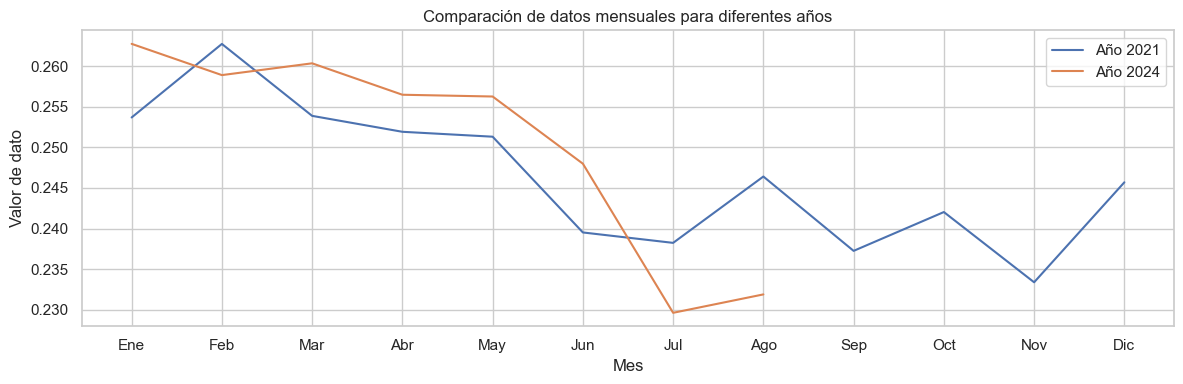

In [367]:
# Filtrar los datos para los años 2022, 2023 y 2024
años_filtrados = [2021, 2024]

# Asegurarse de que los datos estén ordenados por año y mes
df_comparativo_mes.sort_values(by=['año', 'mes'], inplace=True)
fig, ax = plt.subplots(figsize=(12, 4))

# Graficar solo para diferentes años
for year in años_filtrados:
    df_year = df_comparativo_mes[df_comparativo_mes['año'] == year]
    ax.plot(df_year['mes'], df_year['TEA_total'], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title('Comparación de datos mensuales para diferentes años')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor de dato')

meses_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticks(range(1, 13))  # Los meses son del 1 al 12
ax.set_xticklabels(meses_labels)

ax.legend()
plt.tight_layout()
plt.show()

análisis semanal de la TEA

In [10]:
df_comparativo = df_tea_propios_terceros[['FECHA','TEA_total']]
df_comparativo.head()

,FECHA,TEA_total
0,2018-12-31,0.259372
1,2019-01-07,0.249781
2,2019-01-14,0.244724
3,2019-01-21,0.251059
4,2019-01-28,0.255934


In [11]:
# Crear una columna con el número de semana
df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week
df_comparativo['año'] = df_comparativo['FECHA'].dt.year
df_comparativo['mes'] = df_comparativo['FECHA'].dt.strftime('%b')  # 'b' formato de abreviatura de mes (Jan, Feb, etc.)

# Agrupar los datos por semana y año
df_comparativo.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1269066796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1269066796.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo['año'] = df_comparativo['FECHA'].dt.year
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1269066796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,FECHA,TEA_total,semana,año,mes
0,2018-12-31,0.259372,1,2018,Dec
1,2019-01-07,0.249781,2,2019,Jan
2,2019-01-14,0.244724,3,2019,Jan
3,2019-01-21,0.251059,4,2019,Jan
4,2019-01-28,0.255934,5,2019,Jan


In [12]:
df_comparativo = df_comparativo.drop(df_comparativo.index[0])

In [323]:
df_comparativo.head()

,FECHA,TEA_total,semana,año,mes
1,2019-01-07,0.249781,2,2019,Jan
2,2019-01-14,0.244724,3,2019,Jan
3,2019-01-21,0.251059,4,2019,Jan
4,2019-01-28,0.255934,5,2019,Jan
5,2019-02-04,0.251155,6,2019,Feb


In [324]:
df_comparativo['año'].unique()

array([2019, 2020, 2021, 2022, 2023, 2024])

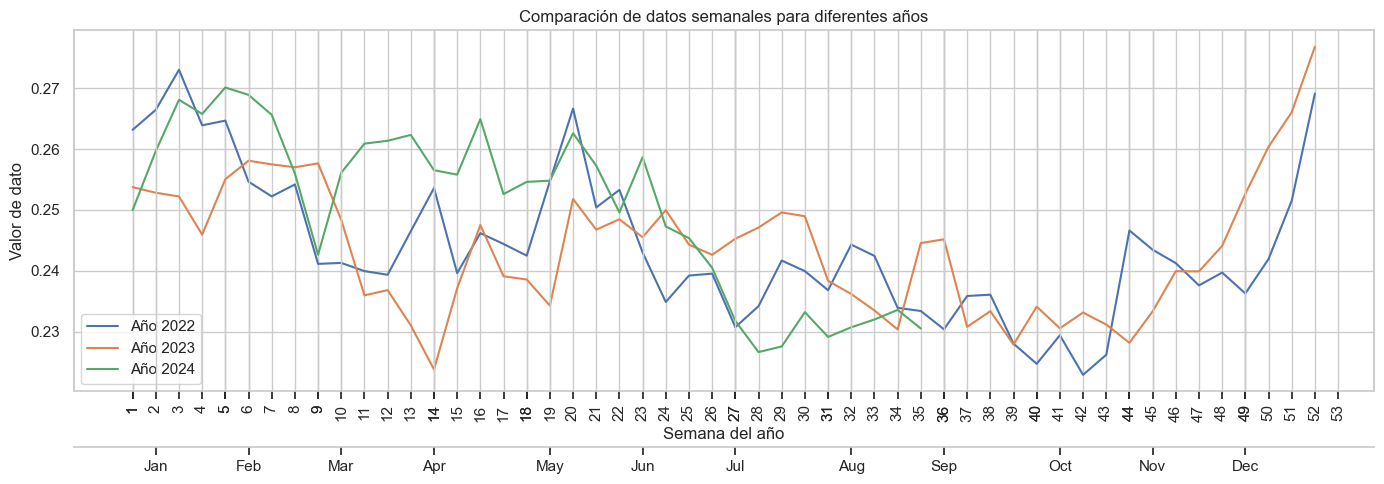

In [368]:
años_filtrados = [2022, 2023, 2024]

# Configurar estilo con seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje de la gráfica
fig, ax = plt.subplots(figsize=(14, 5))

# Graficar solo para los años 2022, 2023 y 2024
for year in años_filtrados:
    df_year = df_comparativo[df_comparativo['año'] == year]
    ax.plot(df_year['semana'], df_year['TEA_total'], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title('Comparación de datos semanales para diferentes años')
ax.set_xlabel('Semana del año')
ax.set_ylabel('Valor de dato')

# Añadir etiquetas de semana en el eje X
weeks_labels = df_comparativo.drop_duplicates(subset=['semana', 'mes'])[['semana', 'mes']]
ax.set_xticks(weeks_labels['semana'])
ax.set_xticklabels(weeks_labels['semana'], rotation=90)

# Crear un segundo eje X para las etiquetas de los meses
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

mes_inicio = df_comparativo.drop_duplicates(subset=['mes'])[['semana', 'mes']]
ax2.set_xticks(mes_inicio['semana'])
ax2.set_xticklabels(mes_inicio['mes'], rotation=0, ha='center')
ax2.xaxis.set_ticks_position('bottom')  # Colocar las etiquetas del segundo eje debajo
ax2.spines['bottom'].set_position(('outward', 40))  # Desplazar hacia abajo

ax2.spines['top'].set_visible(False) # Ocultar la línea del segundo eje (eje superior)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()

# Ajustar la leyenda y cuadrícula
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Analisis de  2018-12-31 00:00:00  hasta  2024-08-26 00:00:00


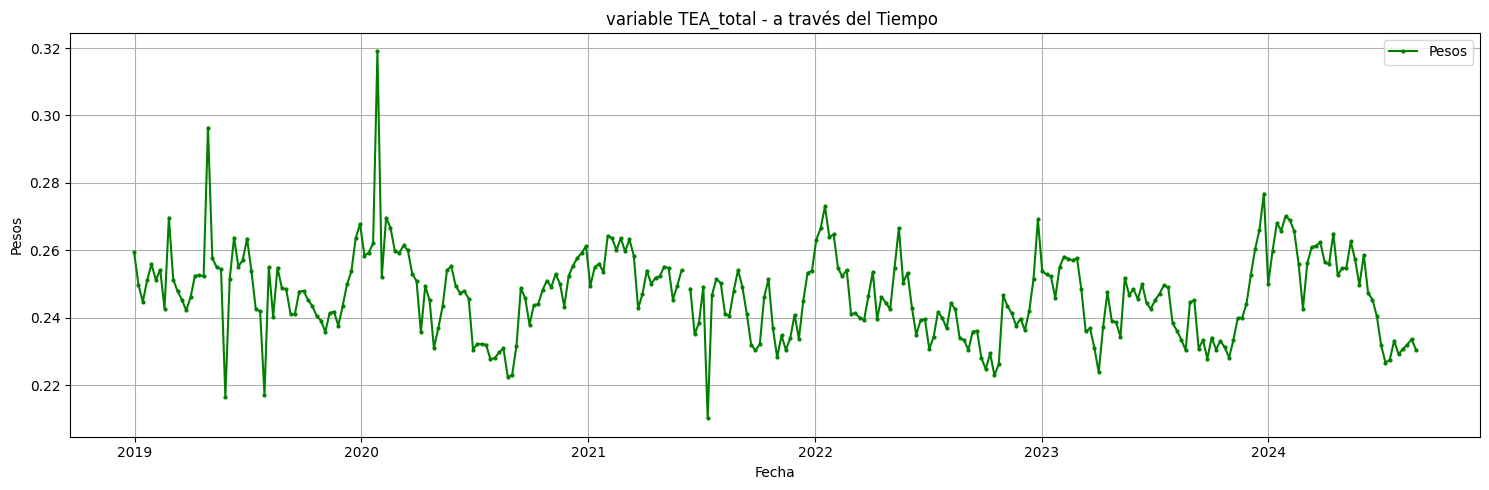

In [292]:
function_tendencia_unica(df_tea_propios_terceros,'TEA_total')

#### Calidad de Racimos Propios

In [13]:
# Completando datos con Peso balanza de Propios y terceros
# ----
df_sabana_balanza_full['FECHA'] = pd.to_datetime(df_sabana_balanza_full['FECHA'])
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])
df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN


In [14]:
print(f'dimension inicial: {df_calidad_racimos_propios_full.shape}')

df_calidad_racimos_propios_full_v2 = pd.merge(df_calidad_racimos_propios_full,
                                              df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS']],
                                              on = ['FECHA','PLANTACION'],
                                              how = 'outer')

df_calidad_racimos_propios_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full_v2['FECHA'])
df_calidad_racimos_propios_full_v2['Peso_propios'] = df_calidad_racimos_propios_full_v2['PROPIOS']*1000
df_calidad_racimos_propios_full_v2['PCTJ'] = df_calidad_racimos_propios_full_v2['Peso']/df_calidad_racimos_propios_full_v2['Peso_propios']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)

print(f'dimension final: {df_calidad_racimos_propios_full_v2.shape}')
df_calidad_racimos_propios_full_v2.head()

dimension inicial: (2538, 11)
dimension final: (5480, 14)


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\381160290.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN
1,2020-01-02,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.66,625660.0,NaN
2,2020-01-02,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
3,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN
4,2020-01-03,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.49,777490.0,NaN


In [15]:
# --------
# ---

min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_propios_filter = df_calidad_racimos_propios_full_v2[df_calidad_racimos_propios_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])

print(df_calidad_racimos_propios_filter.PLANTACION.unique())
df_calidad_racimos_propios_filter.head()

df_sabana_balanza_full: 2020-01-02 00:00:00
df_calidad_racimos_propios_full 2022-01-03 00:00:00
['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\175372827.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
2,2020-01-02,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
5,2020-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.13,14130.0,NaN
8,2020-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45,450.0,NaN
12,2020-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.67,306670.0,NaN
14,2020-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.60,640600.0,NaN


In [16]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2021-08-18') ## --> Para sede Palmawasi
fecha_limite = pd.Timestamp('2022-01-03') ## --> Para sede Shanuzi
# fecha_limite = pd.Timestamp('2020-01-03') ## --> Para sede Tulumayo
# fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede Nuevo Horizonte

df_filtrado =  df_calidad_racimos_propios_filter[df_calidad_racimos_propios_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
1937,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400986e+05,55872.0,879.12,879120.0,0.386863
1940,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082831e+06,71622.0,1145.79,1145790.0,0.945052
1943,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017149e+06,74650.0,1151.49,1151490.0,0.883333
1946,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095006e+06,74774.0,1173.62,1173620.0,0.933015
1949,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.608574e+05,60555.0,922.93,922930.0,0.932744


In [17]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'Peso':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
# resumen_pctj.iloc[0,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)

    AÑO          Peso
0  2022  2.837949e+08
1  2023  2.819689e+08
2  2024  1.499034e+08
---------------------
    AÑO  PCTJ_AÑO
0  2022  1.011472
1  2023  1.016670
2  2024  1.008687


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2804392279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year


In [18]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO
0,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400986e+05,55872.0,879.12,879120.0,0.386863,2022,1.011472
1,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082831e+06,71622.0,1145.79,1145790.0,0.945052,2022,1.011472
2,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017149e+06,74650.0,1151.49,1151490.0,0.883333,2022,1.011472
3,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095006e+06,74774.0,1173.62,1173620.0,0.933015,2022,1.011472
4,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.608574e+05,60555.0,922.93,922930.0,0.932744,2022,1.011472


In [19]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['Peso'].isna(), df_filtrado['Peso_propios'] * df_filtrado['PCTJ_AÑO'], df_filtrado['Peso'])
df_filtrado.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO,Peso_ajustado
0,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400986e+05,55872.0,879.12,879120.0,0.386863,2022,1.011472,3.400986e+05
1,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082831e+06,71622.0,1145.79,1145790.0,0.945052,2022,1.011472,1.082831e+06
2,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017149e+06,74650.0,1151.49,1151490.0,0.883333,2022,1.011472,1.017149e+06
3,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095006e+06,74774.0,1173.62,1173620.0,0.933015,2022,1.011472,1.095006e+06
4,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.608574e+05,60555.0,922.93,922930.0,0.932744,2022,1.011472,8.608574e+05


In [20]:
df_filtrado.tail()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO,Peso_ajustado
975,2024-09-15,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185974.568,11527.0,439.49,439490.0,0.423160,2024,1.008687,1.859746e+05
976,2024-09-16,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,868498.364,51436.0,1126.59,1126590.0,0.770909,2024,1.008687,8.684984e+05
977,2024-09-17,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1307.63,1307630.0,NaN,2024,1.008687,1.318990e+06
978,2024-09-18,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1374.19,1374190.0,NaN,2024,1.008687,1.386128e+06
979,2024-09-19,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.79,14790.0,NaN,2024,1.008687,1.491848e+04


In [21]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_2 = df_filtrado
df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# ----------
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'VERDES':'sum',
                                                                                               'MADUROS':'sum',
                                                                                               'SMADUROS':'sum',
                                                                                               'ESCOBAJO':'sum',
                                                                                               'MALFORMADOA':'sum',
                                                                                               'MALFORMADOB':'sum',
                                                                                               'Peso': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Racimos':'sum',
                                                                                               'Peso_propios':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'VERDES', 'MADUROS', 'SMADUROS', 'ESCOBAJO','MALFORMADOA','MALFORMADOB','Peso','Peso_ajustado','Racimos','Peso_propios']

df_analisis_tendencia_semana_2.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Peso_ajustado,Racimos,Peso_propios
0,2022-01-03,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,4.451012e+06,4.451012e+06,341051.0,5332570.0
1,2022-01-10,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,5.039059e+06,5.078891e+06,350212.0,5452880.0
2,2022-01-17,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,6.533269e+06,6.533269e+06,449793.0,6294980.0
3,2022-01-24,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,5.390967e+06,5.390967e+06,373554.0,5640920.0
4,2022-01-31,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,5.702007e+06,5.702007e+06,297405.0,4469380.0


In [22]:
# Creando variables de calidad
# ----

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_semana_2['Peso_CALIDAD'] = df_analisis_tendencia_semana_2[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_analisis_tendencia_semana_2['%_VERDES'] = df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MADUROS'] = df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_SMADUROS'] = df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_ESCOBAJO'] = df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOA'] = df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOB'] = df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']


df_analisis_tendencia_semana_2['Peso_VERDES'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_SMADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_ESCOBAJO'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOA'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOB'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])

df_analisis_tendencia_semana_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_semana_2['FECHA'])


In [23]:
df_analisis_tendencia_semana_2.tail()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Peso_ajustado,...,%_SMADUROS,%_ESCOBAJO,%_MALFORMADOA,%_MALFORMADOB,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADOA,Peso_MALFORMADOB
137,2024-08-19,Shanuzi,17.0,15501.0,4077.0,300.0,256.0,93.0,6281535.284,6.281535e+06,...,0.204926,0.015079,0.012868,0.004675,5367.484284,4.894198e+06,1.287249e+06,94720.310892,80827.998628,29363.296377
138,2024-08-26,Shanuzi,16.0,14051.0,3579.0,201.0,376.0,78.0,5084007.469,5.114248e+06,...,0.200538,0.011262,0.021068,0.004370,4584.970390,4.026464e+06,1.025601e+06,57598.690525,107746.804166,22351.730652
139,2024-09-02,Shanuzi,6.0,21773.0,5914.0,507.0,711.0,172.0,6029371.623,6.029372e+06,...,0.209716,0.017979,0.025213,0.006099,1282.845026,4.655231e+06,1.264458e+06,108400.404711,152017.135601,36774.890750
140,2024-09-09,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,7750740.831,7.750741e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,2024-09-16,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,868498.364,3.588534e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_analisis_tendencia_semana_2.columns

In [24]:
# Creando df de Calidad Racimos Propios
# -----

columns_rac_propios = ['FECHA', 'PLANTACION','Peso_VERDES','Peso_MADUROS', 'Peso_SMADUROS', 'Peso_ESCOBAJO', 'Peso_MALFORMADOA','Peso_MALFORMADOB']

df_racimos_propios = df_analisis_tendencia_semana_2[columns_rac_propios]
df_racimos_propios.columns = ['FECHA', 'PLANTACION','Peso_VERDES_propios','Peso_MADUROS_propios', 'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios','Peso_MALFORMADOB_propios']

df_racimos_propios.tail()

,FECHA,PLANTACION,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios
137,2024-08-19,Shanuzi,5367.484284,4.894198e+06,1.287249e+06,94720.310892,80827.998628,29363.296377
138,2024-08-26,Shanuzi,4584.970390,4.026464e+06,1.025601e+06,57598.690525,107746.804166,22351.730652
139,2024-09-02,Shanuzi,1282.845026,4.655231e+06,1.264458e+06,108400.404711,152017.135601,36774.890750
140,2024-09-09,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN
141,2024-09-16,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN


Analisis de  2022-01-03 00:00:00  hasta  2024-09-16 00:00:00


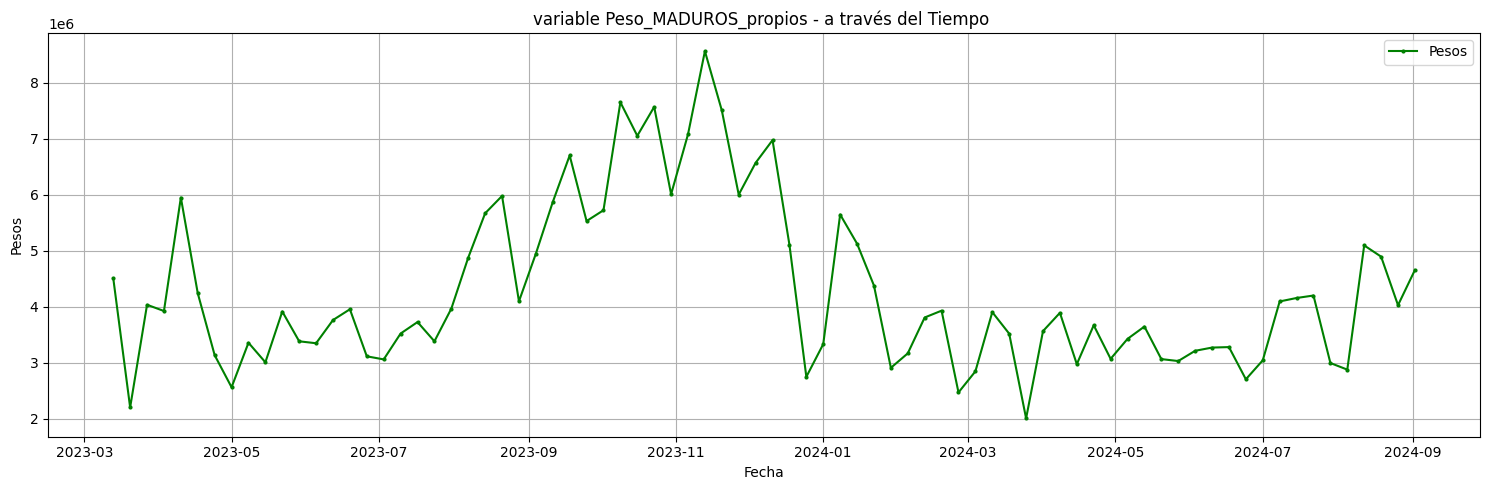

In [25]:
function_tendencia_unica(df_racimos_propios, 'Peso_MADUROS_propios')

análisis mensual

In [382]:
df_racimos_propios.columns

Index(['FECHA', 'PLANTACION', 'Peso_VERDES_propios', 'Peso_MADUROS_propios',
       'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios',
       'Peso_MALFORMADOA_propios', 'Peso_MALFORMADOB_propios'],
      dtype='object')

In [387]:
# Agrupar los datos por mes y año, calculando la media del dato
df_comparativo_filter = df_racimos_propios[['FECHA','Peso_VERDES_propios', 'Peso_MADUROS_propios',
                                            'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios',
                                            'Peso_MALFORMADOA_propios', 'Peso_MALFORMADOB_propios']]
df_comparativo_filter['mes'] = df_comparativo_filter['FECHA'].dt.month
df_comparativo_filter['año'] = df_comparativo_filter['FECHA'].dt.year
# Agrupando variable TEA
df_comparativo_mes = df_comparativo_filter.groupby(['año','mes']).agg({'Peso_VERDES_propios': 'sum',
                                                                       'Peso_MADUROS_propios':'sum',
                                                                       'Peso_SMADUROS_propios':'sum',
                                                                       'Peso_ESCOBAJO_propios':'sum',
                                                                       'Peso_MALFORMADOA_propios':'sum',
                                                                       'Peso_MALFORMADOB_propios':'sum'}).reset_index()
                                                 

df_comparativo_mes.head()


,año,mes,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios
0,2022,1,0.0,0.0,0.0,0.0,0.0,0.0
1,2022,2,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,3,0.0,0.0,0.0,0.0,0.0,0.0
3,2022,4,0.0,0.0,0.0,0.0,0.0,0.0
4,2022,5,0.0,0.0,0.0,0.0,0.0,0.0


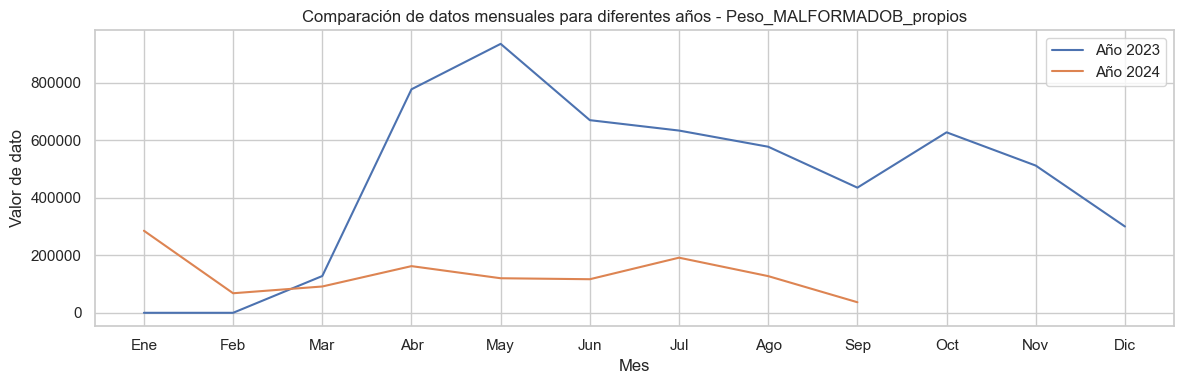

In [400]:

# Filtrar los datos para los años 2022, 2023 y 2024
años_filtrados = [2023, 2024]
# variable_analisis = 'Peso_MADUROS_propios'
# variable_analisis = 'Peso_VERDES_propios'
variable_analisis = 'Peso_MALFORMADOB_propios'

# Asegurarse de que los datos estén ordenados por año y mes
df_comparativo_mes.sort_values(by=['año', 'mes'], inplace=True)
fig, ax = plt.subplots(figsize=(12, 4))

for year in años_filtrados:
    df_year = df_comparativo_mes[df_comparativo_mes['año'] == year]
    ax.plot(df_year['mes'], df_year[variable_analisis], label=f'Año {year}')
ax.set_title(f'Comparación de datos mensuales para diferentes años - {variable_analisis}')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor de dato')
meses_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticks(range(1, 13))  # Los meses son del 1 al 12
ax.set_xticklabels(meses_labels)
ax.legend()
plt.tight_layout()
plt.show()


análisis semanal

In [394]:

df_comparativo = df_racimos_propios[['FECHA','Peso_VERDES_propios', 'Peso_MADUROS_propios',
                                     'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios',
                                     'Peso_MALFORMADOA_propios', 'Peso_MALFORMADOB_propios']]
df_comparativo.head()

# Crear una columna con el número de semana
df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week
df_comparativo['año'] = df_comparativo['FECHA'].dt.year
df_comparativo['mes'] = df_comparativo['FECHA'].dt.strftime('%b')  # 'b' formato de abreviatura de mes (Jan, Feb, etc.)

# Agrupar los datos por semana y año
df_comparativo.head()

,FECHA,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios,semana,año,mes
0,2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1,2022,Jan
1,2022-01-10,NaN,NaN,NaN,NaN,NaN,NaN,2,2022,Jan
2,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,3,2022,Jan
3,2022-01-24,NaN,NaN,NaN,NaN,NaN,NaN,4,2022,Jan
4,2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,5,2022,Jan


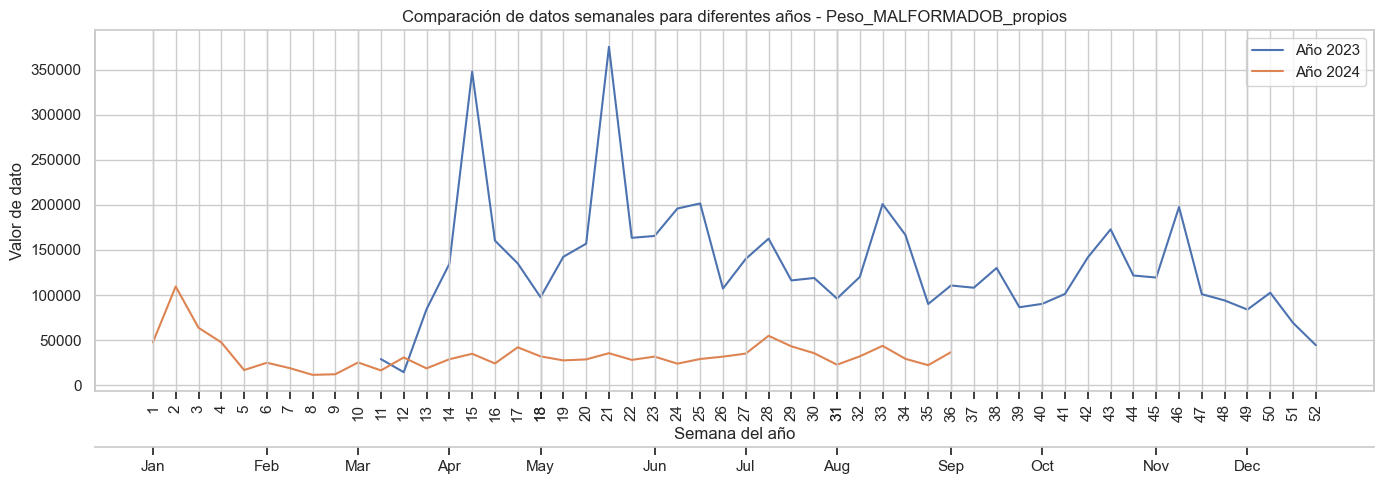

In [399]:

años_filtrados = [2023, 2024]
# variable_analisis = 'Peso_MADUROS_propios'
# variable_analisis = 'Peso_VERDES_propios'
variable_analisis = 'Peso_MALFORMADOB_propios'


# Configurar estilo con seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje de la gráfica
fig, ax = plt.subplots(figsize=(14, 5))

# Graficar solo para los años 2022, 2023 y 2024
for year in años_filtrados:
    df_year = df_comparativo[df_comparativo['año'] == year]
    ax.plot(df_year['semana'], df_year[variable_analisis], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title(f'Comparación de datos semanales para diferentes años - {variable_analisis}')
ax.set_xlabel('Semana del año')
ax.set_ylabel('Valor de dato')

# Añadir etiquetas de semana en el eje X
weeks_labels = df_comparativo.drop_duplicates(subset=['semana', 'mes'])[['semana', 'mes']]
ax.set_xticks(weeks_labels['semana'])
ax.set_xticklabels(weeks_labels['semana'], rotation=90)

# Crear un segundo eje X para las etiquetas de los meses
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

mes_inicio = df_comparativo.drop_duplicates(subset=['mes'])[['semana', 'mes']]
ax2.set_xticks(mes_inicio['semana'])
ax2.set_xticklabels(mes_inicio['mes'], rotation=0, ha='center')
ax2.xaxis.set_ticks_position('bottom')  # Colocar las etiquetas del segundo eje debajo
ax2.spines['bottom'].set_position(('outward', 40))  # Desplazar hacia abajo

ax2.spines['top'].set_visible(False) # Ocultar la línea del segundo eje (eje superior)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()

# Ajustar la leyenda y cuadrícula
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()




#### Calidad de Racimos Terceros

In [26]:
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'])
df_sabana_calidad_terceros_full.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION
0,2024,Enero,2024-01-02,119.10,0.001538,0.899231,0.099231,0.000000,1,0.0,0.0,0.003846153846153846,0.005384615384615384,Palmawasi
1,2024,Enero,2024-01-03,127.62,0.002914,0.901321,0.093629,0.002137,1,0.0,0.0,0.003496503496503497,0.008352758352758352,Palmawasi
2,2024,Enero,2024-01-04,199.01,0.005461,0.912969,0.080546,0.001024,1,0.0,0.0,0.005460750853242321,0.01023890784982935,Palmawasi
3,2024,Enero,2024-01-05,155.34,0.004018,0.900000,0.094866,0.001116,1,0.0,0.0,0.003348214285714286,0.0078125,Palmawasi
4,2024,Enero,2024-01-06,204.82,0.004518,0.904367,0.089910,0.001205,1,0.0,0.0,0.004518072289156626,0.008433734939759036,Palmawasi


In [27]:
print(f'dimension inicial: {df_sabana_calidad_terceros_full.shape}')

df_calidad_racimos_terceros_full_v2 = pd.merge(df_sabana_calidad_terceros_full,
                                               df_sabana_balanza_full[['FECHA','PLANTACION','TERCEROS']],
                                               on = ['FECHA','PLANTACION'],
                                               how = 'outer')

df_calidad_racimos_terceros_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_full_v2['FECHA'])
df_calidad_racimos_terceros_full_v2['Peso_terceros'] = df_calidad_racimos_terceros_full_v2['TERCEROS']*1000

df_calidad_racimos_terceros_full_v2['PCTJ'] = (df_calidad_racimos_terceros_full_v2['PESO NETO T.M.']*1000)/df_calidad_racimos_terceros_full_v2['Peso_terceros']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_terceros_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_calidad_racimos_terceros_full_v2['% MALFORMADO'].replace('-', np.nan, inplace=True)
df_calidad_racimos_terceros_full_v2['% MALFORMADO'] = df_calidad_racimos_terceros_full_v2['% MALFORMADO'].astype('float')

print(f'dimension final: {df_calidad_racimos_terceros_full_v2.shape}')
df_calidad_racimos_terceros_full_v2.head()

dimension inicial: (3038, 14)
dimension final: (5476, 17)


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2638733628.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_calidad_racimos_terceros_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2638733628.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
0,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
1,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palmawasi,0.0,0.0,NaN
2,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
3,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
4,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palmawasi,0.0,0.0,NaN


In [28]:
# Seleccionando la sede para pronosticar
# --------------

min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_sabana_calidad_terceros_full[df_sabana_calidad_terceros_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_terceros_filter = df_calidad_racimos_terceros_full_v2[df_calidad_racimos_terceros_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_terceros_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_filter['FECHA'])

print(df_calidad_racimos_terceros_filter.PLANTACION.unique())
df_calidad_racimos_terceros_filter.head()


df_sabana_balanza_full: 2020-01-02 00:00:00
df_calidad_racimos_propios_full 2022-01-03 00:00:00
['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\3025376969.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calidad_racimos_terceros_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_filter['FECHA'])


,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
2,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
5,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
8,NaN,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
12,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
14,NaN,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN


In [29]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16

fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede shanusi
# fecha_limite = pd.Timestamp('2020-01-03') ## --> Para sede Tulumayo
# fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede Nuevo Horizonte

df_filtrado =  df_calidad_racimos_terceros_filter[df_calidad_racimos_terceros_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
2,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
5,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
8,NaN,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
12,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
14,NaN,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN


In [30]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'PESO NETO T.M.':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
# resumen_pctj.iloc[0,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)


    AÑO  PESO NETO T.M.
0  2020            0.00
1  2021            0.00
2  2022        21544.52
3  2023        26737.06
4  2024        21175.86
---------------------
    AÑO  PCTJ_AÑO
0  2020       NaN
1  2021       NaN
2  2022  0.951024
3  2023  0.992659
4  2024  0.694534


In [31]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ,PCTJ_AÑO
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
4,2020,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN


In [32]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['PESO NETO T.M.'].isna(), df_filtrado['Peso_terceros'] * df_filtrado['PCTJ_AÑO'], df_filtrado['PESO NETO T.M.']*1000)
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ,PCTJ_AÑO,Peso_ajustado
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
4,2020,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN


In [33]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############

df_analisis_tendencia_3 = df_filtrado
df_analisis_tendencia_3['FECHA'] = pd.to_datetime(df_analisis_tendencia_3['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_3['SEMANA'] = df_analisis_tendencia_3['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

In [34]:
# VARIABLES CALIDAD MES
# -------
# ---

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_3['Peso_VERDES'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% VERDES'])
df_analisis_tendencia_3['Peso_MADUROS'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% MADUROS'])
df_analisis_tendencia_3['Peso_SMADUROS'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% SMADUROS'])
df_analisis_tendencia_3['Peso_ESCOBAJO'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% ESCOBAJO'])
df_analisis_tendencia_3['Peso_MALFORMADO'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% MALFORMADO'])

df_analisis_tendencia_3['FECHA'] = pd.to_datetime(df_analisis_tendencia_3['FECHA'])
df_analisis_tendencia_3.head()


,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,...,Peso_terceros,PCTJ,PCTJ_AÑO,Peso_ajustado,SEMANA,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADO
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN
4,2020,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN


In [35]:
# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_3 = df_analisis_tendencia_3.groupby(['SEMANA','PLANTACION']).agg({'Peso_VERDES':'sum',
                                                                                               'Peso_MADUROS':'sum',
                                                                                               'Peso_SMADUROS':'sum',
                                                                                               'Peso_ESCOBAJO':'sum',
                                                                                               'Peso_MALFORMADO':'sum',
                                                                                               'PESO NETO T.M.': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Peso_terceros':'sum'}).reset_index()

df_analisis_tendencia_semana_3.columns = ['FECHA', 'PLANTACION', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS','Peso_ESCOBAJO', 'Peso_MALFORMADO', 'PESO NETO T.M.', 'Peso_ajustado','Peso_terceros']


In [ ]:
df_analisis_tendencia_semana_3.head()

In [36]:
# Creando df de Calidad Racimos Terceros
# -----

columns_rac_terceros = ['FECHA', 'PLANTACION', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS','Peso_ESCOBAJO','Peso_MALFORMADO']

df_racimos_terceros = df_analisis_tendencia_semana_3[columns_rac_terceros]
df_racimos_terceros.columns = ['FECHA', 'PLANTACION', 'Peso_VERDES_terceros', 'Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros']

df_racimos_terceros.tail()

,FECHA,PLANTACION,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,Peso_MALFORMADO_terceros
242,2024-08-19,Shanuzi,11378.016898,275115.113399,8267.711253,1059.158451,2544.677162
243,2024-08-26,Shanuzi,5980.095514,554717.019811,14925.632826,3027.251849,6121.466041
244,2024-09-02,Shanuzi,799.691103,568511.086127,16657.200679,4022.022091,5223.533329
245,2024-09-09,Shanuzi,12494.022551,430296.025567,12135.415397,1094.536485,3579.232183
246,2024-09-16,Shanuzi,0.000000,42983.900689,845.584005,100.515306,309.429174


análisis mensual

In [412]:
df_racimos_terceros.columns

Index(['FECHA', 'PLANTACION', 'Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
       'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros',
       'Peso_MALFORMADO_terceros'],
      dtype='object')

In [414]:
# Agrupar los datos por mes y año, calculando la media del dato
df_comparativo_filter = df_racimos_terceros[['FECHA','Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
                                             'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros',
                                             'Peso_MALFORMADO_terceros']]
df_comparativo_filter['mes'] = df_comparativo_filter['FECHA'].dt.month
df_comparativo_filter['año'] = df_comparativo_filter['FECHA'].dt.year
# Agrupando variable TEA
df_comparativo_mes = df_comparativo_filter.groupby(['año','mes']).agg({'Peso_VERDES_terceros': 'sum',
                                                                       'Peso_MADUROS_terceros':'sum',
                                                                       'Peso_SMADUROS_terceros':'sum',
                                                                       'Peso_ESCOBAJO_terceros':'sum',
                                                                       'Peso_MALFORMADO_terceros':'sum'}).reset_index()
                                                 

df_comparativo_mes.head()

,año,mes,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,Peso_MALFORMADO_terceros
0,2019,12,0.0,0.0,0.0,0.0,0.0
1,2020,1,0.0,0.0,0.0,0.0,0.0
2,2020,2,0.0,0.0,0.0,0.0,0.0
3,2020,3,0.0,0.0,0.0,0.0,0.0
4,2020,4,0.0,0.0,0.0,0.0,0.0


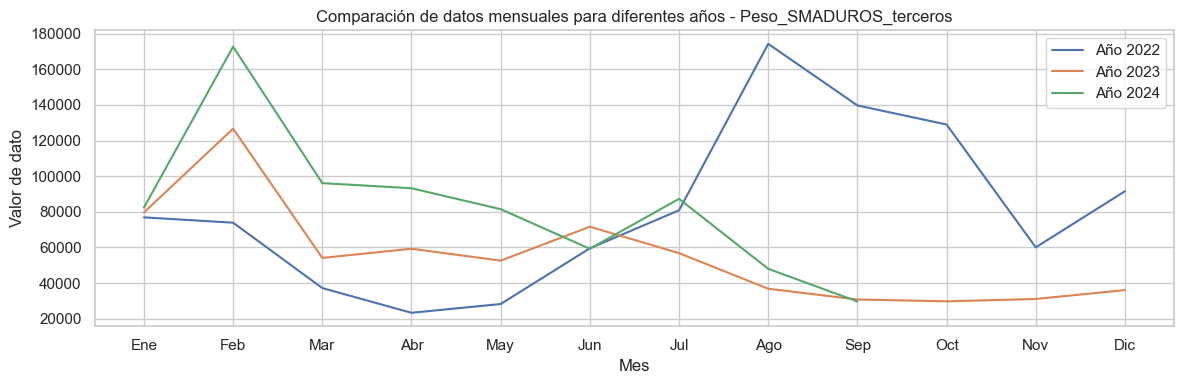

In [428]:

# Filtrar los datos para los años 2022, 2023 y 2024
años_filtrados = [2022, 2023, 2024]
# variable_analisis = 'Peso_MADUROS_terceros'
# variable_analisis = 'Peso_VERDES_terceros'
# variable_analisis = 'Peso_MALFORMADO_terceros'
# variable_analisis = 'Peso_ESCOBAJO_terceros'
variable_analisis = 'Peso_SMADUROS_terceros'

# Asegurarse de que los datos estén ordenados por año y mes
df_comparativo_mes.sort_values(by=['año', 'mes'], inplace=True)
fig, ax = plt.subplots(figsize=(12, 4))

for year in años_filtrados:
    df_year = df_comparativo_mes[df_comparativo_mes['año'] == year]
    ax.plot(df_year['mes'], df_year[variable_analisis], label=f'Año {year}')
ax.set_title(f'Comparación de datos mensuales para diferentes años - {variable_analisis}')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor de dato')
meses_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticks(range(1, 13))  # Los meses son del 1 al 12
ax.set_xticklabels(meses_labels)
ax.legend()
plt.tight_layout()
plt.show()

análisis semanal

In [416]:

df_comparativo = df_racimos_terceros[['FECHA','Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
                                      'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros',
                                      'Peso_MALFORMADO_terceros']]
df_comparativo.head()

# Crear una columna con el número de semana
df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week
df_comparativo['año'] = df_comparativo['FECHA'].dt.year
df_comparativo['mes'] = df_comparativo['FECHA'].dt.strftime('%b')  # 'b' formato de abreviatura de mes (Jan, Feb, etc.)

# Agrupar los datos por semana y año
df_comparativo.head()

,FECHA,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,Peso_MALFORMADO_terceros,semana,año,mes
0,2019-12-30,0.0,0.0,0.0,0.0,0.0,1,2019,Dec
1,2020-01-06,0.0,0.0,0.0,0.0,0.0,2,2020,Jan
2,2020-01-13,0.0,0.0,0.0,0.0,0.0,3,2020,Jan
3,2020-01-20,0.0,0.0,0.0,0.0,0.0,4,2020,Jan
4,2020-01-27,0.0,0.0,0.0,0.0,0.0,5,2020,Jan


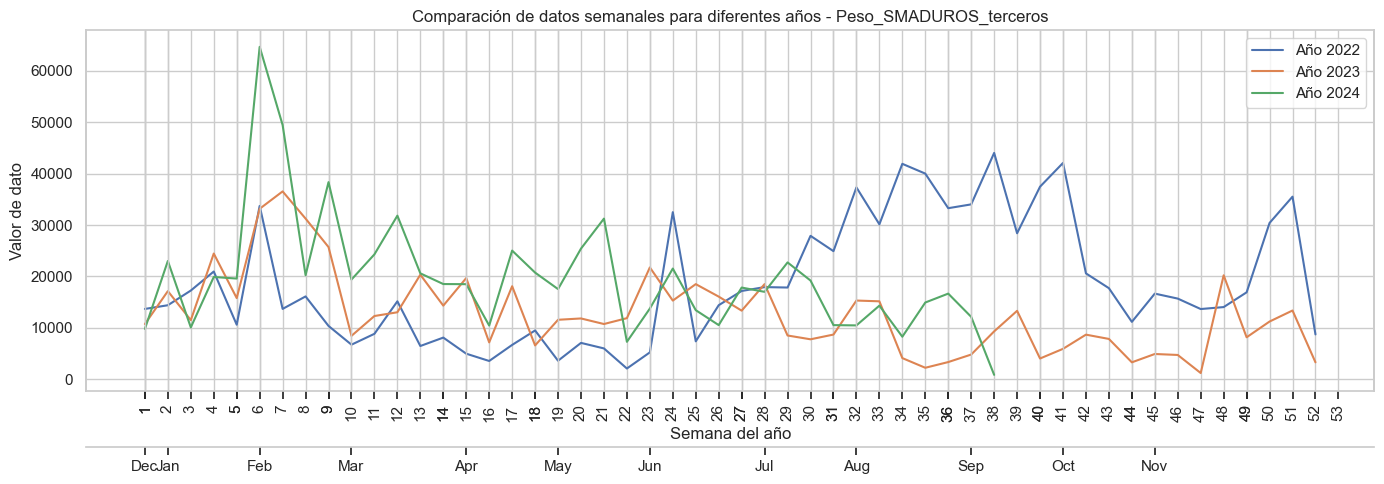

In [427]:
años_filtrados = [2022, 2023, 2024]
# variable_analisis = 'Peso_MADUROS_terceros'
# variable_analisis = 'Peso_VERDES_terceros'
# variable_analisis = 'Peso_MALFORMADO_terceros'
# variable_analisis = 'Peso_ESCOBAJO_terceros'
variable_analisis = 'Peso_SMADUROS_terceros'

# Configurar estilo con seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje de la gráfica
fig, ax = plt.subplots(figsize=(14, 5))

# Graficar solo para los años 2022, 2023 y 2024
for year in años_filtrados:
    df_year = df_comparativo[df_comparativo['año'] == year]
    ax.plot(df_year['semana'], df_year[variable_analisis], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title(f'Comparación de datos semanales para diferentes años - {variable_analisis}')
ax.set_xlabel('Semana del año')
ax.set_ylabel('Valor de dato')

# Añadir etiquetas de semana en el eje X
weeks_labels = df_comparativo.drop_duplicates(subset=['semana', 'mes'])[['semana', 'mes']]
ax.set_xticks(weeks_labels['semana'])
ax.set_xticklabels(weeks_labels['semana'], rotation=90)

# Crear un segundo eje X para las etiquetas de los meses
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

mes_inicio = df_comparativo.drop_duplicates(subset=['mes'])[['semana', 'mes']]
ax2.set_xticks(mes_inicio['semana'])
ax2.set_xticklabels(mes_inicio['mes'], rotation=0, ha='center')
ax2.xaxis.set_ticks_position('bottom')  # Colocar las etiquetas del segundo eje debajo
ax2.spines['bottom'].set_position(('outward', 40))  # Desplazar hacia abajo

ax2.spines['top'].set_visible(False) # Ocultar la línea del segundo eje (eje superior)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()

# Ajustar la leyenda y cuadrícula
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



#### Precipitación

In [37]:
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'])
df_analisis_tendencia_precip =  df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == sede_analisis]
df_analisis_tendencia_precip.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL
3773,2006-08-01,Shanuzi,0.0
3774,2006-08-02,Shanuzi,0.0
3775,2006-08-03,Shanuzi,0.0
3776,2006-08-04,Shanuzi,0.0
3777,2006-08-05,Shanuzi,0.0


In [38]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA'
df_analisis_tendencia_semana_precip = df_analisis_tendencia_precip.groupby(['SEMANA','PLANTACION']).agg({'PRECIPITACION_TOTAL': 'sum'}).reset_index()
df_analisis_tendencia_semana_precip.columns = ['FECHA','PLANTACION','PRECIPITACION_TOTAL']
df_analisis_tendencia_semana_precip.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2783261855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2006-07-31,Shanuzi,0.0
1,2006-08-07,Shanuzi,0.0
2,2006-08-14,Shanuzi,0.0
3,2006-08-21,Shanuzi,2.9
4,2006-08-28,Shanuzi,14.1


In [39]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2_SHIFTED_20'] = df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2'].shift(17)

df_analisis_tendencia_semana_precip.tail()

,FECHA,PLANTACION,PRECIPITACION_TOTAL,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_2_SHIFTED_20
918,2024-03-04,Shanuzi,562.80,682.70,421.68
919,2024-03-11,Shanuzi,464.00,513.40,151.33
920,2024-03-18,Shanuzi,293.20,378.60,381.00
921,2024-03-25,Shanuzi,277.10,285.15,487.40
922,2024-04-01,Shanuzi,245.48,261.29,146.05


In [40]:
# Creando df de Calidad Racimos Terceros
# -----

columns_precipitacion = ['FECHA', 'PLANTACION', 'PRECIPITACION_TOTAL_rolling_2','PRECIPITACION_TOTAL_rolling_2_SHIFTED_20']

df_precipitacion = df_analisis_tendencia_semana_precip[columns_precipitacion]
df_precipitacion.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_2_SHIFTED_20
0,2006-07-31,Shanuzi,NaN,NaN
1,2006-08-07,Shanuzi,0.00,NaN
2,2006-08-14,Shanuzi,0.00,NaN
3,2006-08-21,Shanuzi,1.45,NaN
4,2006-08-28,Shanuzi,8.50,NaN


In [479]:
df_precipitacion.groupby('PLANTACION').agg({'FECHA':['min','max']})

FECHA           
                  min        max
PLANTACION                      
Shanuzi    2006-07-31 2024-04-01

In [473]:
df_calidad_precipitacion_full.groupby('PLANTACION').agg({'FECHA':['min','max']})

FECHA           
                       min        max
PLANTACION                           
Nuevo Horizonte 2019-01-01 2024-03-17
Palmawasi       2019-01-01 2024-03-17
Shanuzi         2006-08-01 2024-04-05
Tulumayo        2022-01-01 2024-04-15

Analisis de  2022-01-03 00:00:00  hasta  2024-04-01 00:00:00


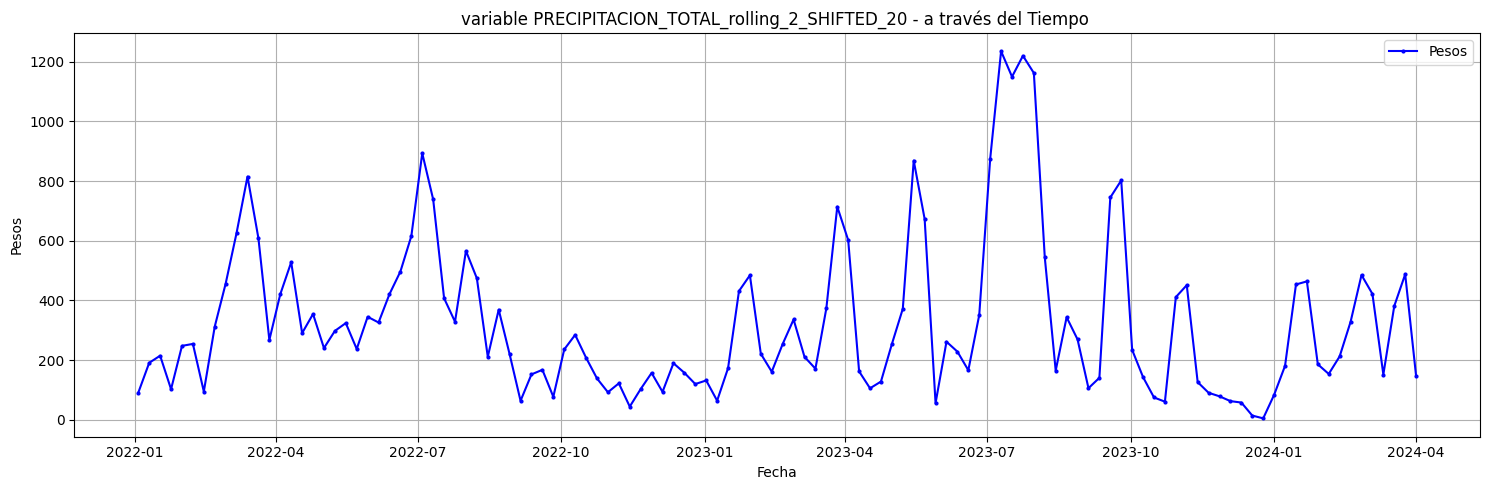

In [41]:
function_tendencia_unica(df_precipitacion[df_precipitacion['FECHA'] >= '2022-01-01'],'PRECIPITACION_TOTAL_rolling_2_SHIFTED_20', 'blue')

análisis mensual

análisis semanal

In [482]:
df_comparativo = df_precipitacion[['FECHA','PRECIPITACION_TOTAL_rolling_2_SHIFTED_20']]
# Crear una columna con el número de semana
df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week
df_comparativo['año'] = df_comparativo['FECHA'].dt.year
df_comparativo['mes'] = df_comparativo['FECHA'].dt.strftime('%b')  # 'b' formato de abreviatura de mes (Jan, Feb, etc.)

# Agrupar los datos por semana y año
df_comparativo.head()


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_6584\840342629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week


,FECHA,PRECIPITACION_TOTAL_rolling_2_SHIFTED_20,semana,año,mes
0,2006-07-31,NaN,31,2006,Jul
1,2006-08-07,NaN,32,2006,Aug
2,2006-08-14,NaN,33,2006,Aug
3,2006-08-21,NaN,34,2006,Aug
4,2006-08-28,NaN,35,2006,Aug


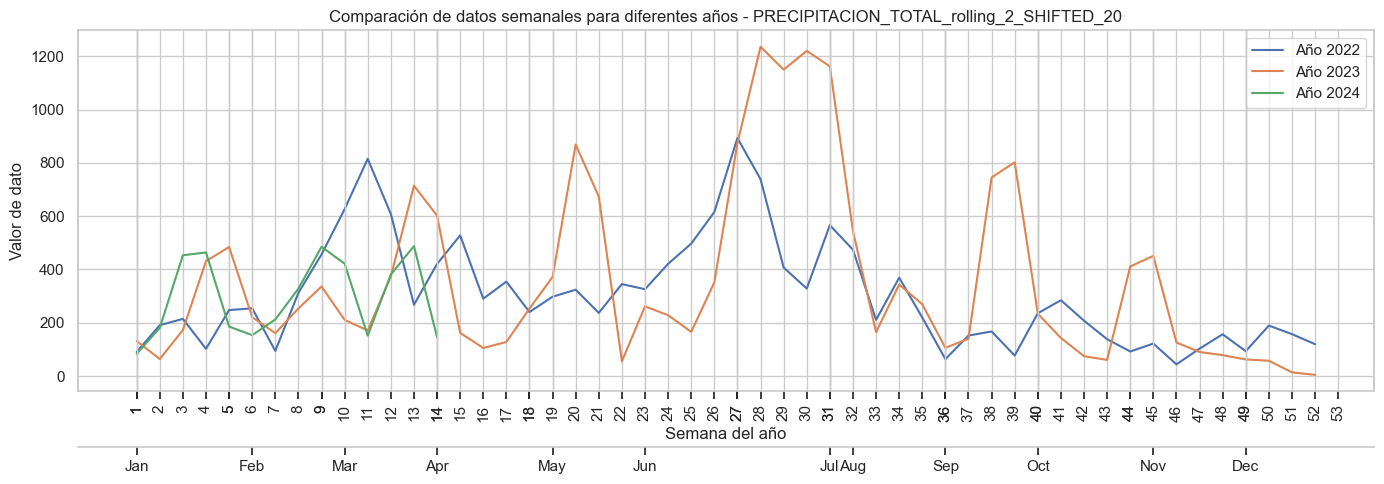

In [483]:
años_filtrados = [2022, 2023, 2024]

# Configurar estilo con seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje de la gráfica
fig, ax = plt.subplots(figsize=(14, 5))

# Graficar solo para los años 2022, 2023 y 2024
for year in años_filtrados:
    df_year = df_comparativo[df_comparativo['año'] == year]
    ax.plot(df_year['semana'], df_year['PRECIPITACION_TOTAL_rolling_2_SHIFTED_20'], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title('Comparación de datos semanales para diferentes años - PRECIPITACION_TOTAL_rolling_2_SHIFTED_20')
ax.set_xlabel('Semana del año')
ax.set_ylabel('Valor de dato')

# Añadir etiquetas de semana en el eje X
weeks_labels = df_comparativo.drop_duplicates(subset=['semana', 'mes'])[['semana', 'mes']]
ax.set_xticks(weeks_labels['semana'])
ax.set_xticklabels(weeks_labels['semana'], rotation=90)

# Crear un segundo eje X para las etiquetas de los meses
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

mes_inicio = df_comparativo.drop_duplicates(subset=['mes'])[['semana', 'mes']]
ax2.set_xticks(mes_inicio['semana'])
ax2.set_xticklabels(mes_inicio['mes'], rotation=0, ha='center')
ax2.xaxis.set_ticks_position('bottom')  # Colocar las etiquetas del segundo eje debajo
ax2.spines['bottom'].set_position(('outward', 40))  # Desplazar hacia abajo

ax2.spines['top'].set_visible(False) # Ocultar la línea del segundo eje (eje superior)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()

# Ajustar la leyenda y cuadrícula
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


#### Saldos en Campo

In [42]:
df_sabana_saldo_campo_full_vf_filter = df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == sede_analisis]
df_sabana_saldo_campo_full_vf_filter['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

# Recode
# ---
df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 2'] = df_sabana_saldo_campo_full_vf_filter['DIA 2'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 3'] = df_sabana_saldo_campo_full_vf_filter['DIA 3'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 4'] = df_sabana_saldo_campo_full_vf_filter['DIA 4'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 5'] = df_sabana_saldo_campo_full_vf_filter['DIA 5'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 6'] = df_sabana_saldo_campo_full_vf_filter['DIA 6'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 7'] = df_sabana_saldo_campo_full_vf_filter['DIA 7'].replace('-',np.nan).astype(float)

df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 2'] = df_sabana_saldo_campo_full_vf_filter['DIA 2'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 3'] = df_sabana_saldo_campo_full_vf_filter['DIA 3'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 4'] = df_sabana_saldo_campo_full_vf_filter['DIA 4'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 5'] = df_sabana_saldo_campo_full_vf_filter['DIA 5'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 6'] = df_sabana_saldo_campo_full_vf_filter['DIA 6'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 7'] = df_sabana_saldo_campo_full_vf_filter['DIA 7'].replace(np.nan,0)


print(df_sabana_saldo_campo_full_vf_filter.PLANTACION.unique())
df_sabana_saldo_campo_full_vf_filter.head()

['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2036236323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2036236323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace('-',np.nan).astype(float)
C:\Users\CESAR QUEZADA\AppData\Local\Temp

,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7
519,2022-01-01,Shanuzi,591.0,7.0,8,516.0,68.0,8.0,0.0,0.0,0.0,0.0
520,2022-01-02,Shanuzi,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521,2022-01-03,Shanuzi,382.0,382.0,382,0.0,0.0,344.0,38.0,0.0,0.0,0.0
522,2022-01-04,Shanuzi,36.0,38.0,38,268.0,0.0,0.0,28.0,0.0,12.0,0.0
523,2022-01-05,Shanuzi,247.0,7.0,8,228.0,12.0,0.0,0.0,0.0,0.0,8.0


In [43]:
# Añadiendo columnas de saldos
# -----
df_sabana_saldo_campo_full_vf_filter['SALDO > 2'] = df_sabana_saldo_campo_full_vf_filter[['DIA 2','DIA 3','DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
df_sabana_saldo_campo_full_vf_filter['SALDO > 4'] = df_sabana_saldo_campo_full_vf_filter[['DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
df_sabana_saldo_campo_full_vf_filter['SALDO > 5'] = df_sabana_saldo_campo_full_vf_filter[['DIA 5','DIA 6','DIA 7']].sum(axis=1)

df_sabana_saldo_campo_full_vf_filter.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1552791295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['SALDO > 2'] = df_sabana_saldo_campo_full_vf_filter[['DIA 2','DIA 3','DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1552791295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['SALDO > 4'] = df_sabana_saldo_campo_full_vf_filter[['DIA 4','DIA 5','DIA 6','DIA 7

,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7,SALDO > 2,SALDO > 4,SALDO > 5
519,2022-01-01,Shanuzi,591.0,7.0,8,516.0,68.0,8.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0
520,2022-01-02,Shanuzi,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521,2022-01-03,Shanuzi,382.0,382.0,382,0.0,0.0,344.0,38.0,0.0,0.0,0.0,382.0,38.0,0.0
522,2022-01-04,Shanuzi,36.0,38.0,38,268.0,0.0,0.0,28.0,0.0,12.0,0.0,40.0,40.0,12.0
523,2022-01-05,Shanuzi,247.0,7.0,8,228.0,12.0,0.0,0.0,0.0,0.0,8.0,20.0,8.0,8.0


In [44]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_saldo_campo = df_sabana_saldo_campo_full_vf_filter
df_analisis_tendencia_2_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_saldo_campo['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo['SEMANA'] = df_analisis_tendencia_2_saldo_campo['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\3326118650.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_saldo_campo['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\3326118650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_saldo_campo['SEMANA'] = df_analisis_tendencia_2_saldo_campo['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7,SALDO > 2,SALDO > 4,SALDO > 5,SEMANA
519,2022-01-01,Shanuzi,591.0,7.0,8,516.0,68.0,8.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0,2021-12-27
520,2022-01-02,Shanuzi,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-12-27
521,2022-01-03,Shanuzi,382.0,382.0,382,0.0,0.0,344.0,38.0,0.0,0.0,0.0,382.0,38.0,0.0,2022-01-03
522,2022-01-04,Shanuzi,36.0,38.0,38,268.0,0.0,0.0,28.0,0.0,12.0,0.0,40.0,40.0,12.0,2022-01-03
523,2022-01-05,Shanuzi,247.0,7.0,8,228.0,12.0,0.0,0.0,0.0,0.0,8.0,20.0,8.0,8.0,2022-01-03


In [45]:
# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_saldo_campo = df_analisis_tendencia_2_saldo_campo.groupby(['SEMANA','PLANTACION']).agg({'SALDO':'sum',
                                                                                           'SALDO > 2':'sum',
                                                                                           'SALDO > 3':'sum',
                                                                                           'SALDO > 4':'sum',
                                                                                           'SALDO > 5':'sum'}).reset_index()

df_saldo_campo.columns = ['FECHA','PLANTACION', 'SALDO','SALDO > 2','SALDO > 3','SALDO > 4','SALDO > 5']
df_saldo_campo.head()

,FECHA,PLANTACION,SALDO,SALDO > 2,SALDO > 3,SALDO > 4,SALDO > 5
0,2021-12-27,Shanuzi,591.0,76.0,7.0,0.0,0.0
1,2022-01-03,Shanuzi,686.0,448.0,427.0,86.0,20.0
2,2022-01-10,Shanuzi,92.0,26.0,22.0,2.0,0.0
3,2022-01-17,Shanuzi,1098.0,232.0,24.0,0.0,0.0
4,2022-01-24,Shanuzi,1354.0,460.0,81.0,16.0,0.0


análisis mensual

In [433]:
df_saldo_campo.columns

Index(['FECHA', 'PLANTACION', 'SALDO', 'SALDO > 2', 'SALDO > 3', 'SALDO > 4',
       'SALDO > 5'],
      dtype='object')

In [46]:
# Agrupar los datos por mes y año, calculando la media del dato
df_comparativo_filter = df_saldo_campo[['FECHA','SALDO', 'SALDO > 2', 'SALDO > 3', 'SALDO > 4','SALDO > 5']]
df_comparativo_filter['mes'] = df_comparativo_filter['FECHA'].dt.month
df_comparativo_filter['año'] = df_comparativo_filter['FECHA'].dt.year
# Agrupando variable TEA
df_comparativo_mes = df_comparativo_filter.groupby(['año','mes']).agg({'SALDO': 'sum',
                                                                       'SALDO > 2':'sum',
                                                                       'SALDO > 3':'sum',
                                                                       'SALDO > 4':'sum',
                                                                       'SALDO > 5':'sum'}).reset_index()

# eliminamos las columnas primigenias
df_comparativo_mes.head()


,año,mes,SALDO,SALDO > 2,SALDO > 3,SALDO > 4,SALDO > 5
0,2021,12,591.0,76.0,7.0,0.0,0.0
1,2022,1,5038.0,1510.0,661.0,132.0,24.0
2,2022,2,5222.0,1062.0,175.0,12.0,0.0
3,2022,3,2215.0,272.0,31.0,14.0,0.0
4,2022,4,2928.0,762.0,137.0,6.0,0.0


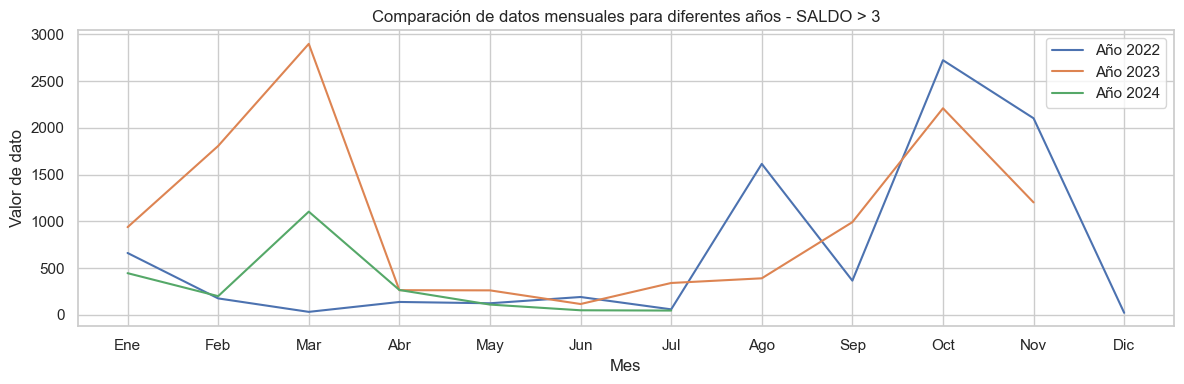

In [466]:

# Filtrar los datos para los años 2022, 2023 y 2024
años_filtrados = [2022, 2023, 2024]
variable_analisis = 'SALDO > 3'

# Asegurarse de que los datos estén ordenados por año y mes
df_comparativo_mes.sort_values(by=['año', 'mes'], inplace=True)
fig, ax = plt.subplots(figsize=(12, 4))

# Graficar solo para diferentes años
for year in años_filtrados:
    df_year = df_comparativo_mes[df_comparativo_mes['año'] == year]
    ax.plot(df_year['mes'], df_year[variable_analisis], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title(f'Comparación de datos mensuales para diferentes años - {variable_analisis}')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor de dato')

meses_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticks(range(1, 13))  # Los meses son del 1 al 12
ax.set_xticklabels(meses_labels)

ax.legend()
plt.tight_layout()
plt.show()


análisis semanal

In [467]:
df_comparativo = df_saldo_campo[['FECHA','SALDO', 'SALDO > 2', 'SALDO > 3', 'SALDO > 4','SALDO > 5']]
df_comparativo.head()

# Crear una columna con el número de semana
df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week
df_comparativo['año'] = df_comparativo['FECHA'].dt.year
df_comparativo['mes'] = df_comparativo['FECHA'].dt.strftime('%b')  # 'b' formato de abreviatura de mes (Jan, Feb, etc.)

# Agrupar los datos por semana y año
df_comparativo.head()

,FECHA,SALDO,SALDO > 2,SALDO > 3,SALDO > 4,SALDO > 5,semana,año,mes
0,2021-12-27,591.0,76.0,7.0,0.0,0.0,52,2021,Dec
1,2022-01-03,686.0,448.0,427.0,86.0,20.0,1,2022,Jan
2,2022-01-10,92.0,26.0,22.0,2.0,0.0,2,2022,Jan
3,2022-01-17,1098.0,232.0,24.0,0.0,0.0,3,2022,Jan
4,2022-01-24,1354.0,460.0,81.0,16.0,0.0,4,2022,Jan


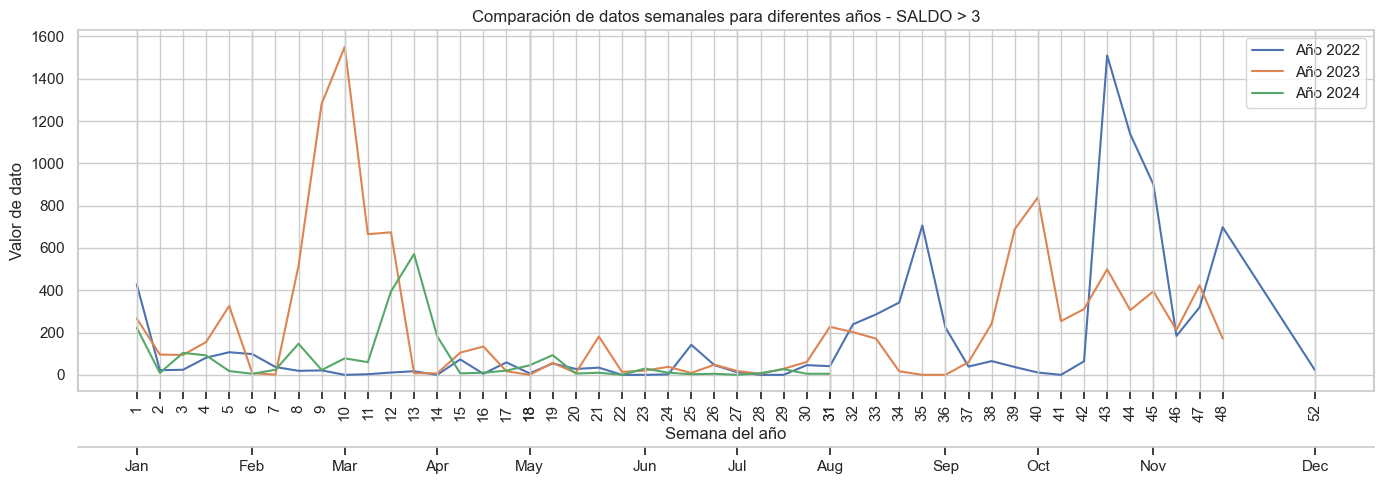

In [468]:
años_filtrados = [2022, 2023, 2024]
variable_analisis = 'SALDO > 3'

# Configurar estilo con seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje de la gráfica
fig, ax = plt.subplots(figsize=(14, 5))

# Graficar solo para los años 2022, 2023 y 2024
for year in años_filtrados:
    df_year = df_comparativo[df_comparativo['año'] == year]
    ax.plot(df_year['semana'], df_year[variable_analisis], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title(f'Comparación de datos semanales para diferentes años - {variable_analisis}')
ax.set_xlabel('Semana del año')
ax.set_ylabel('Valor de dato')

# Añadir etiquetas de semana en el eje X
weeks_labels = df_comparativo.drop_duplicates(subset=['semana', 'mes'])[['semana', 'mes']]
ax.set_xticks(weeks_labels['semana'])
ax.set_xticklabels(weeks_labels['semana'], rotation=90)

# Crear un segundo eje X para las etiquetas de los meses
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

mes_inicio = df_comparativo.drop_duplicates(subset=['mes'])[['semana', 'mes']]
ax2.set_xticks(mes_inicio['semana'])
ax2.set_xticklabels(mes_inicio['mes'], rotation=0, ha='center')
ax2.xaxis.set_ticks_position('bottom')  # Colocar las etiquetas del segundo eje debajo
ax2.spines['bottom'].set_position(('outward', 40))  # Desplazar hacia abajo

ax2.spines['top'].set_visible(False) # Ocultar la línea del segundo eje (eje superior)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()

# Ajustar la leyenda y cuadrícula
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


#### Perdidas en Fabrica

In [47]:
print(df_perdida_aceite_full.PLANTACION.unique())
df_perdida_aceite_full.head()

['Nuevo Horizonte' 'Palmawasi' 'Shanuzi' 'Tulumayo']


,AÑO,MES,DIA,RFF PROCESADO,TM CONDENSADO,TM ACEITE CONDENSADO,% PERDIDA ACEITE CONDENSADO,TM ESCOBAJO SIN PICAR,TM ACEITE ESCOBAJO SIN PICAR,% PERDIDA ACEITE ESCOBAJO SIN PICAR,...,LODO,FRUTO ADHERIDO,ARENA,TM ACEITE ESCOBAJO,TM ACEITE ESCOBAJO_CMPTO,TM ACEITE CONDENSADO_CMPTO,TM ACEITE FIBRA_CMPTO,TM ACEITE AGUA TD_CMPTO,TM ACEITE EN ARENA_CMPTO,TM ACEITE CASCARA_CMPTO
0,2020.0,Enero,2020-01-01 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020.0,Enero,2020-01-01 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020.0,Enero,2020-01-01 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020.0,Enero,2020-01-02 00:00:00,0.00,0.0000,0.0,-,0.0,0.0,-,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020.0,Enero,2020-01-02 00:00:00,914.62,192.0702,0.0,0,0.0,0.0,0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Variable pérdidas
# ---------

df_perdida_aceite_full.columns

# TM ACEITE CONDENSADO

# TM ACEITE ESCOBAJO SIN PICAR
# TM ACEITE ESCOBAJO PICADO

# TM ACEITE RACIMO MAL DESFRUTADO

# TM ACEITE FIBRA

# TM ACEITE AGUA TD

# TM ACEITE SOLIDO TD

# TM ACEITE EN ARENA

# TM ACEITE CASCARA

# Hay nuevas perdidas que no los quieren conciderar
# ----------
# TM RACIMOS DUROS
# TM RACIMOS MAL DESFRUTADOS

In [48]:
# Filtrando la base total por sedes
# --------

# Creamos PERDIDA EN ACEITE ESCOBAJO
# ----
# df_perdida_aceite_full['TM ACEITE ESCOBAJO'] = df_perdida_aceite_full['TM ACEITE ESCOBAJO SIN PICAR'] + df_perdida_aceite_full['TM ACEITE ESCOBAJO PICADO']

df_perdida_aceite_full['TM PERDIDA TOTAL'] = (
    df_perdida_aceite_full['TM ACEITE CONDENSADO_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE ESCOBAJO_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE RACIMO MAL DESFRUTADO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE FIBRA_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE AGUA TD_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE SOLIDO TD'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE EN ARENA_CMPTO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE CASCARA_CMPTO'].fillna(0)
)# ----

df_perdida_aceite_full_filter = df_perdida_aceite_full[df_perdida_aceite_full['PLANTACION'] == sede_analisis]
df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])

print(df_perdida_aceite_full_filter.PLANTACION.unique())
df_perdida_aceite_full_filter.tail()

['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\466264551.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])


,AÑO,MES,DIA,RFF PROCESADO,TM CONDENSADO,TM ACEITE CONDENSADO,% PERDIDA ACEITE CONDENSADO,TM ESCOBAJO SIN PICAR,TM ACEITE ESCOBAJO SIN PICAR,% PERDIDA ACEITE ESCOBAJO SIN PICAR,...,FRUTO ADHERIDO,ARENA,TM ACEITE ESCOBAJO,TM ACEITE ESCOBAJO_CMPTO,TM ACEITE CONDENSADO_CMPTO,TM ACEITE FIBRA_CMPTO,TM ACEITE AGUA TD_CMPTO,TM ACEITE EN ARENA_CMPTO,TM ACEITE CASCARA_CMPTO,TM PERDIDA TOTAL
6471,2024.0,Diciembre,2024-12-27 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6474,2024.0,Diciembre,2024-12-28 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6477,2024.0,Diciembre,2024-12-29 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6480,2024.0,Diciembre,2024-12-30 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6483,2024.0,Diciembre,2024-12-31 00:00:00,0.0,0.0,0.0,-,0.0,0.0,-,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
df_perdida_aceite_full_filter[df_perdida_aceite_full_filter['AÑO'] == 2023].head()

In [49]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_perdida_aceite = df_perdida_aceite_full_filter
df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2_perdida_aceite = df_analisis_tendencia_2_perdida_aceite.groupby(['SEMANA','PLANTACION']).agg({'TM PERDIDA TOTAL':'sum',
                                                                                                                             'TM ACEITE CONDENSADO_CMPTO':'sum',
                                                                                                                             'TM ACEITE ESCOBAJO_CMPTO':'sum',
                                                                                                                             'TM ACEITE RACIMO MAL DESFRUTADO':'sum',
                                                                                                                             'TM ACEITE FIBRA_CMPTO':'sum',
                                                                                                                             'TM ACEITE AGUA TD_CMPTO':'sum',
                                                                                                                             'TM ACEITE SOLIDO TD':'sum',
                                                                                                                             'TM ACEITE EN ARENA_CMPTO':'sum',
                                                                                                                             'TM ACEITE CASCARA_CMPTO':'sum'}).reset_index()

df_analisis_tendencia_semana_2_perdida_aceite.columns = ['FECHA','PLANTACION','TM PERDIDA TOTAL' ,'TM ACEITE CONDENSADO', 'TM ACEITE ESCOBAJO','TM ACEITE RACIMO MAL DESFRUTADO', 'TM ACEITE FIBRA','TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD', 'TM ACEITE EN ARENA','TM ACEITE CASCARA']
df_analisis_tendencia_semana_2_perdida_aceite.head()


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2245403583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\2245403583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2019-12-30,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-06,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-13,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-20,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-27,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df_perdidas_aceite = df_analisis_tendencia_semana_2_perdida_aceite
df_perdidas_aceite.head()

,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2019-12-30,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-06,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-13,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-20,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-27,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_perdidas_aceite[df_perdidas_aceite['FECHA']>'2023-01-01'].head()

Analisis de  2019-12-30 00:00:00  hasta  2024-12-30 00:00:00


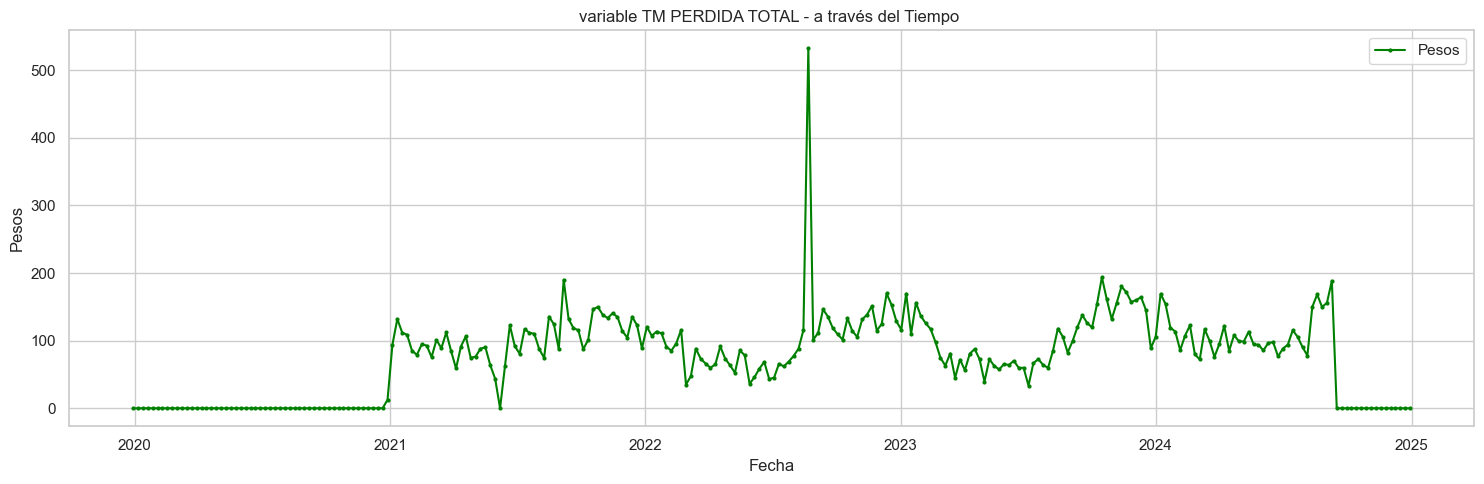

In [450]:
function_tendencia_unica(df_perdidas_aceite, 'TM PERDIDA TOTAL')

In [451]:
df_perdidas_aceite[df_perdidas_aceite['TM PERDIDA TOTAL'] > 200].head()

,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
138,2022-08-22,Shanuzi,532.194226,416.088,57.173,0.0,43.800244,13.322981,0.0,0.0,1.81


análisis mensual

In [51]:
# Imputando el valor atípico
outlier_index = 138  # índice del valor atípico
mean_neighbors = (df_perdidas_aceite['TM PERDIDA TOTAL'][outlier_index - 1] + df_perdidas_aceite['TM PERDIDA TOTAL'][outlier_index + 1]) / 2 # Calcular el promedio de los puntos aledaños
df_perdidas_aceite.loc[outlier_index, 'TM PERDIDA TOTAL'] = mean_neighbors
df_perdidas_aceite[df_perdidas_aceite['TM PERDIDA TOTAL'] > 200].head()


,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA


Analisis de  2019-12-30 00:00:00  hasta  2024-12-30 00:00:00


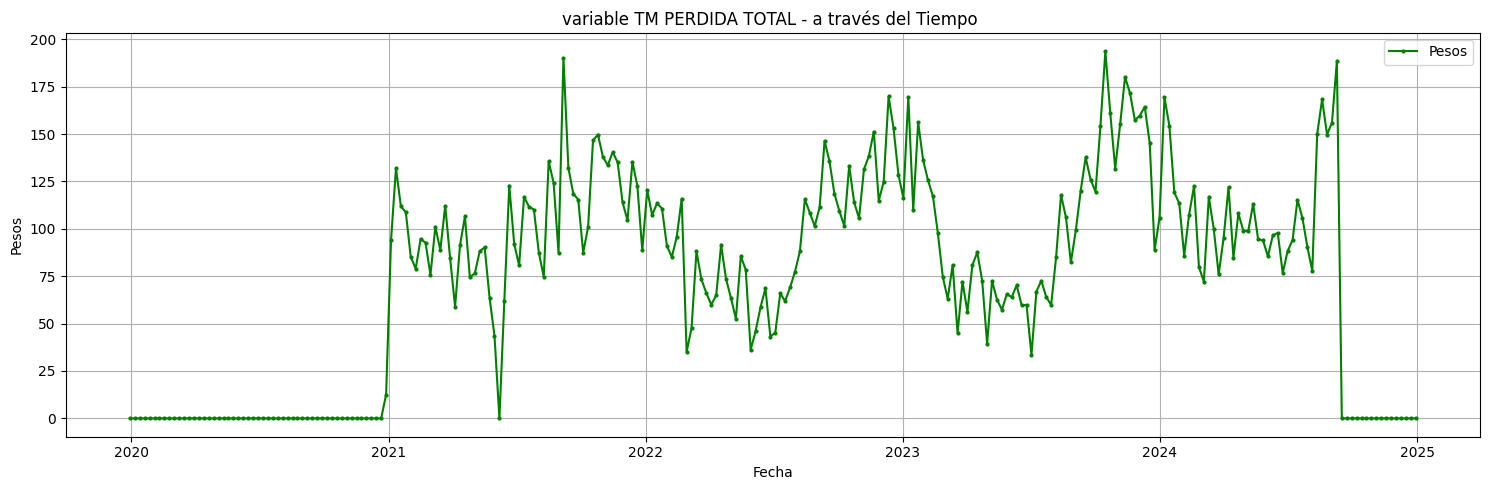

In [52]:
function_tendencia_unica(df_perdidas_aceite, 'TM PERDIDA TOTAL')

In [444]:
df_perdidas_aceite.columns

Index(['FECHA', 'PLANTACION', 'TM PERDIDA TOTAL', 'TM ACEITE CONDENSADO',
       'TM ACEITE ESCOBAJO', 'TM ACEITE RACIMO MAL DESFRUTADO',
       'TM ACEITE FIBRA', 'TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD',
       'TM ACEITE EN ARENA', 'TM ACEITE CASCARA'],
      dtype='object')

In [455]:
# Agrupar los datos por mes y año, calculando la media del dato
df_comparativo_filter = df_perdidas_aceite[['FECHA','TM PERDIDA TOTAL', 'TM ACEITE CONDENSADO',
                                            'TM ACEITE ESCOBAJO', 'TM ACEITE RACIMO MAL DESFRUTADO',
                                            'TM ACEITE FIBRA', 'TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD',
                                            'TM ACEITE EN ARENA', 'TM ACEITE CASCARA']]
df_comparativo_filter['mes'] = df_comparativo_filter['FECHA'].dt.month
df_comparativo_filter['año'] = df_comparativo_filter['FECHA'].dt.year
# Agrupando variable TEA
df_comparativo_mes = df_comparativo_filter.groupby(['año','mes']).agg({'TM PERDIDA TOTAL': 'sum',
                                                                       'TM ACEITE CONDENSADO':'sum',
                                                                       'TM ACEITE ESCOBAJO':'sum',
                                                                       'TM ACEITE RACIMO MAL DESFRUTADO':'sum',
                                                                       'TM ACEITE FIBRA':'sum',
                                                                       'TM ACEITE AGUA TD':'sum',
                                                                       'TM ACEITE SOLIDO TD':'sum',
                                                                       'TM ACEITE EN ARENA':'sum',
                                                                       'TM ACEITE CASCARA':'sum'}).reset_index()

df_comparativo_mes.head()


,año,mes,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2019,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


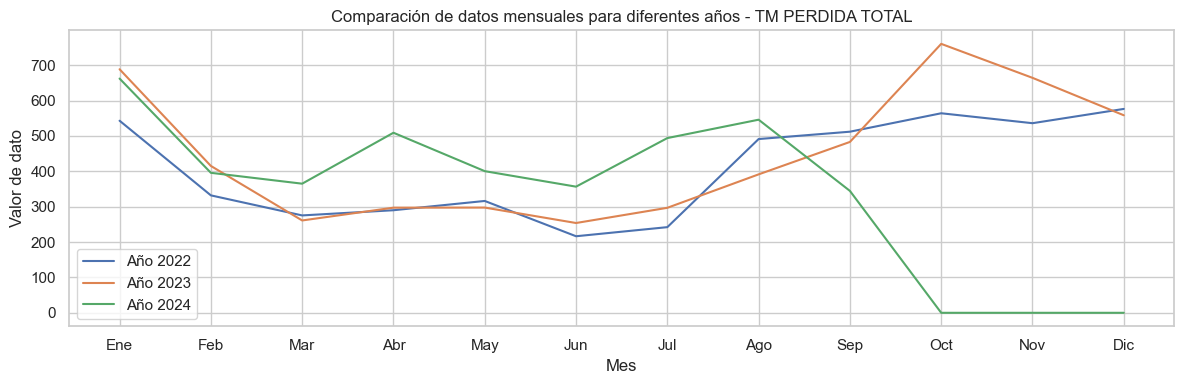

In [456]:
# Filtrar los datos para los años 2022, 2023 y 2024
años_filtrados = [2022, 2023, 2024]
variable_analisis = 'TM PERDIDA TOTAL'


# Asegurarse de que los datos estén ordenados por año y mes
df_comparativo_mes.sort_values(by=['año', 'mes'], inplace=True)
fig, ax = plt.subplots(figsize=(12, 4))

# Graficar solo para diferentes años
for year in años_filtrados:
    df_year = df_comparativo_mes[df_comparativo_mes['año'] == year]
    ax.plot(df_year['mes'], df_year[variable_analisis], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title(f'Comparación de datos mensuales para diferentes años - {variable_analisis}')
ax.set_xlabel('Mes')
ax.set_ylabel('Valor de dato')

meses_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticks(range(1, 13))  # Los meses son del 1 al 12
ax.set_xticklabels(meses_labels)

ax.legend()
plt.tight_layout()
plt.show()


análisis semanal

In [459]:
df_comparativo = df_perdidas_aceite[['FECHA','TM PERDIDA TOTAL', 'TM ACEITE CONDENSADO',
                                     'TM ACEITE ESCOBAJO', 'TM ACEITE RACIMO MAL DESFRUTADO',
                                     'TM ACEITE FIBRA', 'TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD',
                                     'TM ACEITE EN ARENA', 'TM ACEITE CASCARA']]
df_comparativo.head()

# Crear una columna con el número de semana
df_comparativo['semana'] = df_comparativo['FECHA'].dt.isocalendar().week
df_comparativo['año'] = df_comparativo['FECHA'].dt.year
df_comparativo['mes'] = df_comparativo['FECHA'].dt.strftime('%b')  # 'b' formato de abreviatura de mes (Jan, Feb, etc.)

# Agrupar los datos por semana y año
df_comparativo.head()

,FECHA,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,semana,año,mes
0,2019-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2019,Dec
1,2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2020,Jan
2,2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2020,Jan
3,2020-01-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2020,Jan
4,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2020,Jan


In [460]:
df_comparativo = df_comparativo.drop(df_comparativo.index[0])

In [462]:
df_comparativo.tail()

,FECHA,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,semana,año,mes
257,2024-12-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,2024,Dec
258,2024-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,2024,Dec
259,2024-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,2024,Dec
260,2024-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52,2024,Dec
261,2024-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2024,Dec


In [464]:
function_save(df_comparativo)

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


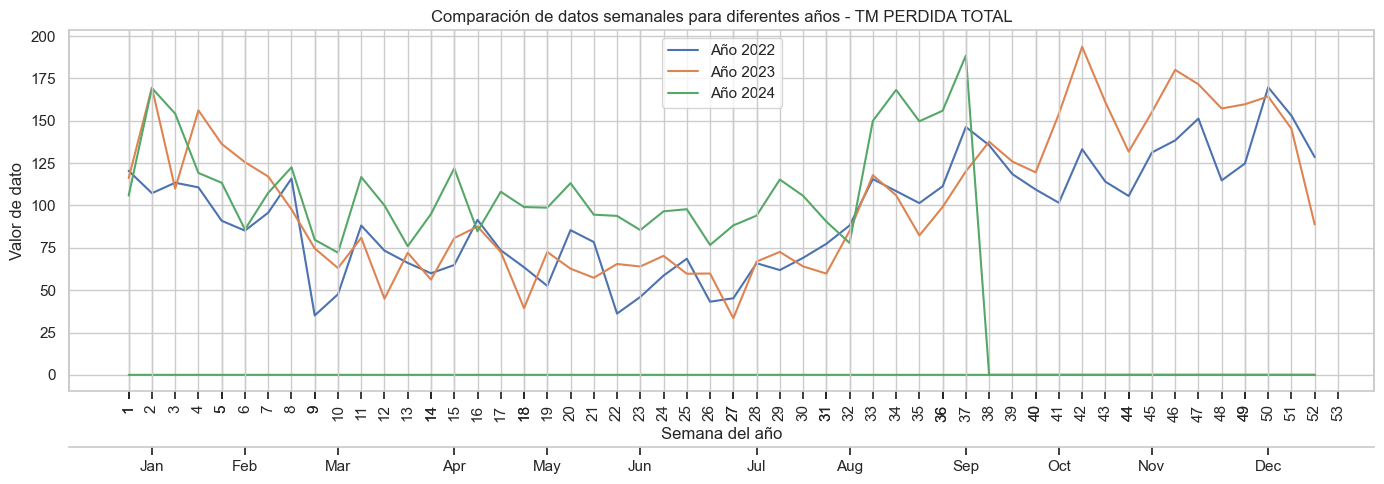

In [461]:
años_filtrados = [2022, 2023, 2024]
variable_analisis = 'TM PERDIDA TOTAL'


# Configurar estilo con seaborn
sns.set(style="whitegrid")

# Crear la figura y el eje de la gráfica
fig, ax = plt.subplots(figsize=(14, 5))

# Graficar solo para los años 2022, 2023 y 2024
for year in años_filtrados:
    df_year = df_comparativo[df_comparativo['año'] == year]
    ax.plot(df_year['semana'], df_year[variable_analisis], label=f'Año {year}')

# Configuración de la gráfica
ax.set_title(f'Comparación de datos semanales para diferentes años - {variable_analisis}')
ax.set_xlabel('Semana del año')
ax.set_ylabel('Valor de dato')

# Añadir etiquetas de semana en el eje X
weeks_labels = df_comparativo.drop_duplicates(subset=['semana', 'mes'])[['semana', 'mes']]
ax.set_xticks(weeks_labels['semana'])
ax.set_xticklabels(weeks_labels['semana'], rotation=90)

# Crear un segundo eje X para las etiquetas de los meses
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

mes_inicio = df_comparativo.drop_duplicates(subset=['mes'])[['semana', 'mes']]
ax2.set_xticks(mes_inicio['semana'])
ax2.set_xticklabels(mes_inicio['mes'], rotation=0, ha='center')
ax2.xaxis.set_ticks_position('bottom')  # Colocar las etiquetas del segundo eje debajo
ax2.spines['bottom'].set_position(('outward', 40))  # Desplazar hacia abajo

ax2.spines['top'].set_visible(False) # Ocultar la línea del segundo eje (eje superior)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()

# Ajustar la leyenda y cuadrícula
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



#### Polinizadores

In [53]:
print(df_polinizadores_full.PLANTACION.unique())
df_polinizadores_full.head()

['Palmawasi' 'Shanuzi']


,year,month,Mes_txt,PLANTACION,NumInsectos,PromInsectosFlor,PromInsectosHa,day,FECHA
0,2018,1,Ene,Palmawasi,512099,11.40,55.91,1,2018-01-01
1,2018,2,Feb,Palmawasi,550568,10.10,52.41,1,2018-02-01
2,2018,3,Mar,Palmawasi,492468,10.29,51.22,1,2018-03-01
3,2018,4,Abr,Palmawasi,487876,10.05,56.25,1,2018-04-01
4,2018,5,May,Palmawasi,579719,10.35,69.26,1,2018-05-01


In [54]:
df_polinizadores_full['FECHA'] = pd.to_datetime(df_polinizadores_full['FECHA'])
df_polinizadores_full_filter =  df_polinizadores_full[df_polinizadores_full['PLANTACION'] == sede_analisis]

print(df_polinizadores_full_filter.PLANTACION.unique())
df_polinizadores_full_filter.head()

['Shanuzi']


,year,month,Mes_txt,PLANTACION,NumInsectos,PromInsectosFlor,PromInsectosHa,day,FECHA
78,2019,1,Ene,Shanuzi,505645,10.728483,66.395746,1,2019-01-01
79,2019,2,Feb,Shanuzi,431653,9.437781,66.748058,1,2019-02-01
80,2019,3,Mar,Shanuzi,414635,9.401973,88.580347,1,2019-03-01
81,2019,4,Abr,Shanuzi,447982,9.588233,99.272197,1,2019-04-01
82,2019,5,May,Shanuzi,508891,10.485670,108.812965,1,2019-05-01


In [55]:
# Crear una lista para almacenar los nuevos registros semanales
data_semanal = []

# Iterar sobre cada registro mensual
for index, row in df_polinizadores_full_filter.iterrows():
    fecha = row['FECHA']
    prom_insectos_flor = row['PromInsectosFlor']
    prom_insectos_ha = row['PromInsectosHa']
    num_insectos = row['NumInsectos']
    
    # Calcular la cantidad de semanas en el mes
    # Se considera que cada semana empieza el lunes
    inicio_mes = fecha
    fin_mes = inicio_mes + pd.offsets.MonthEnd(0)
    semanas_en_mes = pd.date_range(start=inicio_mes, end=fin_mes, freq='W-MON')
    
    # Número de semanas en el mes
    num_semanas = len(semanas_en_mes)
    
    # Calcular el número de insectos por semana
    num_insectos_por_semana = num_insectos / num_semanas
    
    # Crear un nuevo registro para cada semana
    for semana in semanas_en_mes:
        data_semanal.append({
            'FECHA': semana,
            'PromInsectosFlor': prom_insectos_flor,
            'PromInsectosHa': prom_insectos_ha,
            'NumInsectos': num_insectos_por_semana
        })

In [56]:
# Crear un nuevo DataFrame con los datos semanales
df_polinizadores_semanal = pd.DataFrame(data_semanal)
df_polinizadores_semanal['PLANTACION'] = sede_analisis
df_polinizadores_semanal.head(10)

,FECHA,PromInsectosFlor,PromInsectosHa,NumInsectos,PLANTACION
0,2019-01-07,10.728483,66.395746,126411.25,Shanuzi
1,2019-01-14,10.728483,66.395746,126411.25,Shanuzi
2,2019-01-21,10.728483,66.395746,126411.25,Shanuzi
3,2019-01-28,10.728483,66.395746,126411.25,Shanuzi
4,2019-02-04,9.437781,66.748058,107913.25,Shanuzi
5,2019-02-11,9.437781,66.748058,107913.25,Shanuzi
6,2019-02-18,9.437781,66.748058,107913.25,Shanuzi
7,2019-02-25,9.437781,66.748058,107913.25,Shanuzi
8,2019-03-04,9.401973,88.580347,103658.75,Shanuzi
9,2019-03-11,9.401973,88.580347,103658.75,Shanuzi


Analisis de  2019-01-07 00:00:00  hasta  2024-07-29 00:00:00


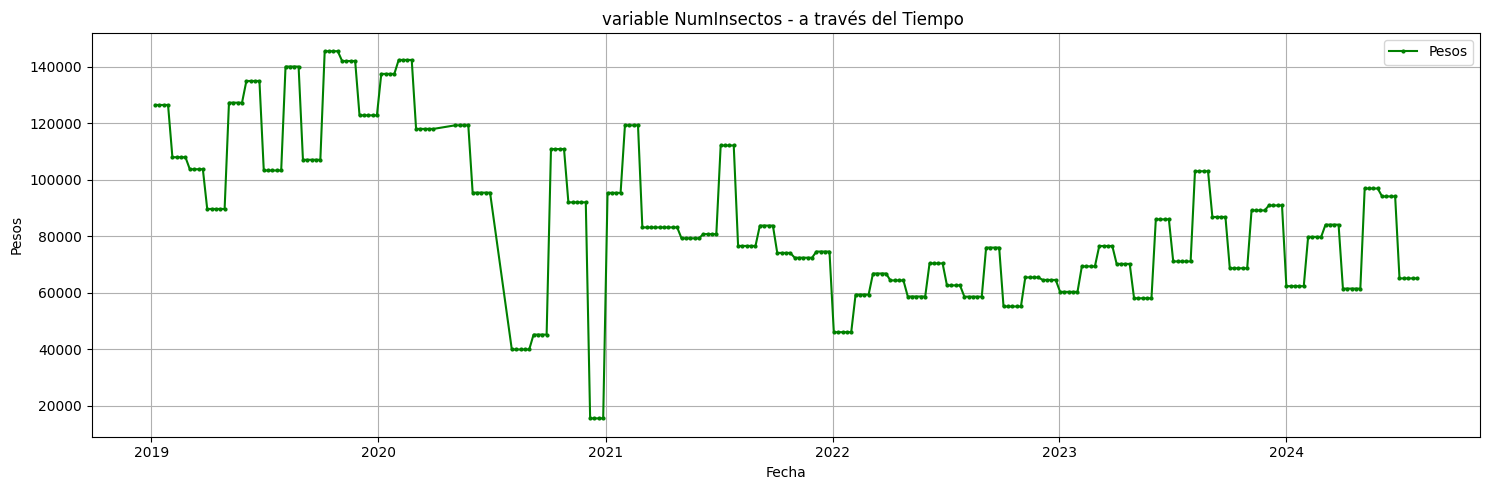

In [57]:
function_tendencia_unica(df_polinizadores_semanal, 'NumInsectos')

In [58]:
df_polinizadores_semanal['NumInsectos_SHIFTED_20'] = df_polinizadores_semanal['NumInsectos'].shift(20)
df_polinizadores_semanal.head()

,FECHA,PromInsectosFlor,PromInsectosHa,NumInsectos,PLANTACION,NumInsectos_SHIFTED_20
0,2019-01-07,10.728483,66.395746,126411.25,Shanuzi,NaN
1,2019-01-14,10.728483,66.395746,126411.25,Shanuzi,NaN
2,2019-01-21,10.728483,66.395746,126411.25,Shanuzi,NaN
3,2019-01-28,10.728483,66.395746,126411.25,Shanuzi,NaN
4,2019-02-04,9.437781,66.748058,107913.25,Shanuzi,NaN


In [60]:
df_polinizadores_sem = df_polinizadores_semanal[['FECHA','PLANTACION','NumInsectos','NumInsectos_SHIFTED_20']]
df_polinizadores_sem

,FECHA,PLANTACION,NumInsectos,NumInsectos_SHIFTED_20
0,2019-01-07,Shanuzi,126411.25,NaN
1,2019-01-14,Shanuzi,126411.25,NaN
2,2019-01-21,Shanuzi,126411.25,NaN
3,2019-01-28,Shanuzi,126411.25,NaN
4,2019-02-04,Shanuzi,107913.25,NaN
...,...,...,...,...
278,2024-07-01,Shanuzi,65018.40,79718.75
279,2024-07-08,Shanuzi,65018.40,79718.75
280,2024-07-15,Shanuzi,65018.40,79718.75
281,2024-07-22,Shanuzi,65018.40,84036.75


#### Consolidando df para modelo

In [ ]:
df_tea_propios_terceros
df_racimos_propios
df_racimos_terceros
df_precipitacion
df_saldo_campo
df_perdidas_aceite
df_polinizadores_sem

In [ ]:
# df_tea_propios_terceros[df_tea_propios_terceros['FECHA'] > '2022-01-01'].head() ## shanusi
df_tea_propios_terceros[df_tea_propios_terceros['FECHA'] > '2019-12-20'].head() ## shanusi

In [ ]:
df_racimos_terceros.head()

In [61]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
# ---------------
# -----------
df_model_match = pd.merge(df_tea_propios_terceros,df_racimos_propios,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_racimos_terceros,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_precipitacion,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_saldo_campo,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_perdidas_aceite,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_polinizadores_sem,on=['FECHA', 'PLANTACION'], how='outer')


# Convertir 'FECHA' a formato datetime
df_model_match['FECHA'] = pd.to_datetime(df_model_match['FECHA'])

print(df_model_match.PLANTACION.unique())
print('df_model_match:',df_model_match.shape)
print('-------------')
print('df_tea_propios_terceros:',df_tea_propios_terceros.shape)
print('df_racimos_propios:',df_racimos_propios.shape)
print('df_racimos_terceros:',df_racimos_terceros.shape)
print('df_precipitacion:',df_precipitacion.shape)
print('df_saldo_campo:',df_saldo_campo.shape)
print('df_perdidas_aceite:',df_perdidas_aceite.shape)
print('df_polinizadores_sem:',df_polinizadores_sem.shape)

df_model_match.head()


['Shanuzi']
df_model_match: (962, 36)
-------------
df_tea_propios_terceros: (296, 7)
df_racimos_propios: (142, 8)
df_racimos_terceros: (247, 7)
df_precipitacion: (923, 4)
df_saldo_campo: (129, 7)
df_perdidas_aceite: (262, 11)
df_polinizadores_sem: (283, 4)


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,NumInsectos,NumInsectos_SHIFTED_20
0,2006-07-31,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-08-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-08-14,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-08-21,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-08-28,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_model_match[df_model_match['FECHA']>'2023-01-01'].head()

In [ ]:
function_save(df_model_match)

In [62]:
# Extraer el año de la columna FECHA
df_model_match['anio'] = df_model_match['FECHA'].dt.year
df_model_match.head()

,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,NumInsectos,NumInsectos_SHIFTED_20,anio
0,2006-07-31,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
1,2006-08-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
2,2006-08-14,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
3,2006-08-21,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
4,2006-08-28,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006


In [63]:
# Reemplazar valores de 0 por np.nan en todo el DataFrame
df_model_match.replace(0, np.nan, inplace=True)

# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_model_match.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_model_match.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1522600855.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_model_match.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1522600855.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes

Valores Perdidos Absolutos            \
anio                                                           2006 2007 2008   
Peso_MALFORMADOB_propios                                         22   53   52   
Peso_VERDES_terceros                                             22   53   52   
Peso_MADUROS_terceros                                            22   53   52   
Peso_SMADUROS_terceros                                           22   53   52   
Peso_ESCOBAJO_terceros                                           22   53   52   
Peso_MALFORMADO_terceros                                         22   53   52   
PRECIPITACION_TOTAL_rolling_2                                     3    0    0   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_20                         20    0    0   
SALDO                                                            22   53   52   
SALDO > 2                                                        22   53   52   
SALDO > 3                                                        22   53   52   
SALDO > 4                                                        22   53   52   
SALDO > 5                                                        22   53   52   
TM PERDIDA TOTAL                                                 22   53   52   
TM ACEITE CONDENSADO                                             22   53   52   
TM ACEITE ESCOBAJO                                               22   53   52   
TM ACEITE RACIMO MAL DESFRUTADO                                  22   53   52   
TM ACEITE FIBRA                                                  22   53   52   
TM ACEITE AGUA TD                                                22   53   52   
TM ACEITE SOLIDO TD                                              22   53   52   
TM ACEITE EN ARENA                                               22   53   52   
TM ACEITE CASCARA                                                22   53   52   
NumInsectos                                                      22   53   52   
NumInsectos_SHIFTED_20                                           22   53   52   
anio                                                              0    0    0   

                                                                             \
anio                                     2009 2010 2011 2012 2013 2014 2015   
Peso_MALFORMADOB_propios                   52   52   52   53   52   52   52   
Peso_VERDES_terceros                       52   52   52   53   52   52   52   
Peso_MADUROS_terceros                      52   52   52   53   52   52   52   
Peso_SMADUROS_terceros                     52   52   52   53   52   52   52   
Peso_ESCOBAJO_terceros                     52   52   52   53   52   52   52   
Peso_MALFORMADO_terceros                   52   52   52   53   52   52   52   
PRECIPITACION_TOTAL_rolling_2               0    1    0    0    0    0    0   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_20    0    1    0    0    0    0    0   
SALDO                                      52   52   52   53   52   52   52   
SALDO > 2                                  52   52   52   53   52   52   52   
SALDO > 3                                  52   52   52   53   52   52   52   
SALDO > 4                                  52   52   52   53   52   52   52   
SALDO > 5                                  52   52   52   53   52   52   52   
TM PERDIDA TOTAL                           52   52   52   53   52   52   52   
TM ACEITE CONDENSADO                       52   52   52   53   52   52   52   
TM ACEITE ESCOBAJO                         52   52   52   53   52   52   52   
TM ACEITE RACIMO MAL DESFRUTADO            52   52   52   53   52   52   52   
TM ACEITE FIBRA                            52   52   52   53   52   52   52   
TM ACEITE AGUA TD                          52   52   52   53   52   52   52   
TM ACEITE SOLIDO TD                        52   52   52   53   52   52   52   
TM ACEITE EN ARENA                         52   52   52   53   52   52   52   
TM ACEITE CASCARA                   

In [64]:
# Reducimos la base de datos para trabajar con poca presencia de valores perdidos
# -----
fecha_limite_sem_inf = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi

fecha_limite_sem_sup = pd.Timestamp('2024-09-20') ## --> Para sede Shanuzi
# fecha_limite_sem_sup = pd.Timestamp('2024-07-01') ## --> Para sede Shanuzi

df_regresion =  df_model_match[df_model_match['FECHA'] >= fecha_limite_sem_inf]
df_regresion =  df_regresion[df_regresion['FECHA'] < fecha_limite_sem_sup]
df_regresion.head()


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,NumInsectos,NumInsectos_SHIFTED_20,anio
866,2023-03-06,Shanuzi,0.248372,4605.700,4215.240,390.46,1143.925,NaN,NaN,NaN,...,29.362,NaN,27.508,4.89,NaN,NaN,0.26,76477.75,55076.40,2023
867,2023-03-13,Shanuzi,0.235963,5813.999,5321.459,492.54,1371.886,151553.916591,4.511324e+06,431824.858231,...,34.567,NaN,36.420,8.30,NaN,NaN,0.34,76477.75,55076.40,2023
868,2023-03-20,Shanuzi,0.236822,3104.499,2744.489,360.01,735.214,25750.693994,2.198585e+06,371954.468807,...,23.664,NaN,17.379,3.03,NaN,NaN,0.15,76477.75,55076.40,2023
869,2023-03-27,Shanuzi,0.231031,5022.049,4639.879,382.17,1160.251,42185.337052,4.033880e+06,880341.375853,...,32.992,NaN,31.131,5.90,NaN,NaN,0.31,76477.75,65365.75,2023
870,2023-04-03,Shanuzi,0.223784,3779.589,3546.189,233.40,845.813,44222.216255,3.922463e+06,768420.445889,...,30.028,NaN,21.180,4.13,NaN,NaN,0.19,70144.75,65365.75,2023


In [65]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1673673285.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_1728\1673673285.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes =

Valores Perdidos Absolutos       \
anio                                                           2023 2024   
Peso_MALFORMADOB_propios                                          1    2   
Peso_VERDES_terceros                                              3    2   
Peso_MADUROS_terceros                                             0    0   
Peso_SMADUROS_terceros                                            0    0   
Peso_ESCOBAJO_terceros                                            0    0   
Peso_MALFORMADO_terceros                                          0    0   
PRECIPITACION_TOTAL_rolling_2                                     0   24   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_20                          0   24   
SALDO                                                             4    7   
SALDO > 2                                                         4    7   
SALDO > 3                                                         7    9   
SALDO > 4                                                        17   21   
SALDO > 5                                                        29   32   
TM PERDIDA TOTAL                                                  0    1   
TM ACEITE CONDENSADO                                              0    1   
TM ACEITE ESCOBAJO                                                0    1   
TM ACEITE RACIMO MAL DESFRUTADO                                  43    1   
TM ACEITE FIBRA                                                   0    1   
TM ACEITE AGUA TD                                                 0    1   
TM ACEITE SOLIDO TD                                              43    1   
TM ACEITE EN ARENA                                               21    1   
TM ACEITE CASCARA                                                 0    1   
NumInsectos                                                       0    7   
NumInsectos_SHIFTED_20                                            0    7   
anio                                                              0    0   

                                         Porcentaje         
anio                                           2023   2024  
Peso_MALFORMADOB_propios                       2.33   5.26  
Peso_VERDES_terceros                           6.98   5.26  
Peso_MADUROS_terceros                          0.00   0.00  
Peso_SMADUROS_terceros                         0.00   0.00  
Peso_ESCOBAJO_terceros                         0.00   0.00  
Peso_MALFORMADO_terceros                       0.00   0.00  
PRECIPITACION_TOTAL_rolling_2                  0.00  63.16  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_20       0.00  63.16  
SALDO                                          9.30  18.42  
SALDO > 2                                      9.30  18.42  
SALDO > 3                                     16.28  23.68  
SALDO > 4                                     39.53  55.26  
SALDO > 5                                     67.44  84.21  
TM PERDIDA TOTAL                               0.00   2.63  
TM ACEITE CONDENSADO                           0.00   2.63  
TM ACEITE ESCOBAJO                             0.00   2.63  
TM ACEITE RACIMO MAL DESFRUTADO              100.00   2.63  
TM ACEITE FIBRA                                0.00   2.63  
TM ACEITE AGUA TD                              0.00   2.63  
TM ACEITE SOLIDO TD                          100.00   2.63  
TM ACEITE EN ARENA                            48.84   2.63  
TM ACEITE CASCARA                              0.00   2.63  
NumInsectos                                    0.00  18.42  
NumInsectos_SHIFTED_20                         0.00  18.42  
anio                                           0.00   0.00

In [ ]:
df_regresion.columns
df_regresion.tail()

In [ ]:
# function_tendencia_unica(df_regresion, 'PRECIPITACION_TOTAL_rolling_2_SHIFTED_24')
# function_tendencia_unica(df_regresion, 'SALDO > 5')
function_tendencia_unica(df_regresion, 'Peso_MALFORMADOA_propios')

In [ ]:
df_regresion.columns

In [ ]:
## PROCESAMIENTO BASE SEMANAL
## --------------------------

df_tendencia_inter_conf = df_regresion[['FECHA','Peso_MADUROS_propios']]
val_col = df_tendencia_inter_conf.columns[1]

# --
# --
# Agregar columnas para el año y el mes (combinados) al que pertenece cada semana
df_tendencia_inter_conf['año_mes'] = df_tendencia_inter_conf['FECHA'].dt.to_period('M')  # Combina año y mes

df_tendencia_inter_conf.columns = ['FECHA','valor','año_mes']

## PROCESAMIENTO BASE MENSUAL
## --------------------------

# Agrupar por año-mes para obtener los valores medios, mínimos y máximos a nivel mensual
df_tendencia_inter_mensual = df_tendencia_inter_conf.groupby('año_mes').agg({
    'valor': ['mean', 'min', 'max']  # Media, mínimo y máximo por mes y año
})
df_tendencia_inter_mensual.columns = ['valor_medio', 'min_conf', 'max_conf']
df_tendencia_inter_mensual.reset_index(inplace=True)


## PROCESAMIENTO MERGE
## --------------------------

df_tendencia_inter_conf = df_tendencia_inter_conf.merge(df_tendencia_inter_mensual, how='left', on='año_mes')



## PROCESAMIENTO PENALIZACION
## --------------------------
penalizacion_min = 0.95  # Ejemplo de penalización: 5% reducción en el mínimo
penalizacion_max = 0.95  # Ejemplo de penalización: 5% aumento en el máximo


df_tendencia_inter_conf['min_conf_penalizado'] = df_tendencia_inter_conf['min_conf'] * penalizacion_min
df_tendencia_inter_conf['max_conf_penalizado'] = df_tendencia_inter_conf['max_conf'] * penalizacion_max



df_tendencia_inter_conf.head()

In [ ]:
# Crear el gráfico
plt.figure(figsize=(15, 5))

# Graficar el valor semanal
plt.plot(df_tendencia_inter_conf['FECHA'], df_tendencia_inter_conf['valor'], label='Valor semanal', color='blue')

# Agregar el intervalo de confianza mensual aplicado a nivel semanal
plt.fill_between(df_tendencia_inter_conf['FECHA'], df_tendencia_inter_conf['min_conf_penalizado'], df_tendencia_inter_conf['max_conf_penalizado'], color='blue', alpha=0.2, label='Intervalo de confianza mensual')

# Añadir etiquetas y leyenda
plt.title(f'Gráfico semanal con intervalo de confianza mensual: {val_col}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
df_regresion.columns

In [66]:
# colums_caja = ['Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios',
#                'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios',
#                'Peso_MALFORMADOB_propios']

colums_caja = ['Peso_VERDES_propios', 'Peso_SMADUROS_propios',
               'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios',
               'Peso_MALFORMADOB_propios']

In [ ]:
# Crear un gráfico de cajas para todas las variables
# df_model.plot(kind='box', figsize=(20, 8))
df_regresion[colums_caja].plot(kind='box', figsize=(20, 8))

# Mostrar el gráfico
plt.title('Gráfico de Cajas para Múltiples Variables')
plt.show()

In [ ]:
for k, v in df_regresion[colums_caja].items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(df_regresion[colums_caja])[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

In [58]:
# Eliminamos variables con mucha presencia de missing
# -----
del df_regresion['TM ACEITE SOLIDO TD'] # Muchos valores vacios
del df_regresion['TM ACEITE EN ARENA'] # Muchos valores vacios
del df_regresion['TM ACEITE RACIMO MAL DESFRUTADO'] # Muchos valores vacios

In [ ]:
df_regresion.tail(30)

In [59]:
# Eliminando valores perdidos del restante de variables
# -----
df_regresion['Peso_ESCOBAJO_propios'] = df_regresion['Peso_ESCOBAJO_propios'].replace(np.nan,0) # Reemplanzando valores escobajo por cero
df_regresion['SALDO > 3'] = df_regresion['SALDO > 3'].replace(np.nan,0) # Reemplanzando valores escobajo por cero
df_regresion['SALDO > 4'] = df_regresion['SALDO > 4'].replace(np.nan,0) # Reemplanzando valores escobajo por cero
df_regresion['SALDO > 5'] = df_regresion['SALDO > 5'].replace(np.nan,0) # Reemplanzando valores escobajo por cero

df_regresion['Peso_VERDES_terceros'] = df_regresion['Peso_VERDES_terceros'].replace(np.nan,0) # Reemplanzando valores escobajo por cero


In [ ]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)

In [ ]:
# df_regresion[df_regresion['Peso_VERDES_terceros'].isnull()][['Peso_VERDES_terceros','Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros', 'Peso_MALFORMADO_terceros']].head()
# df_regresion[df_regresion['Peso_SMADUROS_propios'].isnull()][['Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios','Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios','Peso_MALFORMADOB_propios']].head()
# df_regresion.loc[866]

In [ ]:
# Interpolación lineal
# -----
df_regresion['FECHA'] = pd.to_datetime(df_regresion['FECHA'])
# Establecer la columna FECHA como índice
df_regresion.set_index('FECHA', inplace=True)
df_regresion = df_regresion.interpolate(method='time')


In [ ]:
# Interpolación hacia adelante usando el siguiente valor no nulo
df_regresion = df_regresion.fillna(method='bfill')

In [ ]:
# O, para modificar el DataFrame original directamente:
print('df_regresion_origin: ',df_regresion.shape)
df_regresion.dropna(inplace=True)
print('df_regresion_drop: ',df_regresion.shape)

In [ ]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(20)

In [ ]:
# Recuperar el índice como una columna en el DataFrame
df_regresion = df_regresion.reset_index()
df_regresion.head()

In [ ]:
# function_tendencia_unica(df_regresion, 'Peso_MADUROS_propios')
function_tendencia_unica(df_regresion, 'NumInsectos_SHIFTED_20')


#### Creando variables tipo tiempo

In [67]:
df_regresion['mes'] = df_model_match['FECHA'].dt.month
df_regresion['semana'] = df_regresion['FECHA'].dt.isocalendar().week

# Reemplazar los valores de la columna 'año'
df_regresion['anio'] = df_regresion['anio'].replace({2023: 0, 2024: 1})

In [ ]:
df_regresion.tail()

In [ ]:
df_regresion.columns

In [68]:
# Lista de columnas que deseas combertir a TN
columnas_a_TN = ['SALDO','SALDO > 2','SALDO > 3', 'SALDO > 4', 'SALDO > 5',
                 'TM PERDIDA TOTAL','TM ACEITE CONDENSADO','TM ACEITE ESCOBAJO',
                 'TM ACEITE FIBRA', 'TM ACEITE AGUA TD','TM ACEITE CASCARA','TM ACEITE RACIMO MAL DESFRUTADO']

# Aplicar el suavizado y crear nuevas columnas con un bucle for
for columna in columnas_a_TN:
    nueva_columna = f'{columna}_TN'
    df_regresion[nueva_columna] = df_regresion[columna]*1000


In [ ]:
df_regresion.columns

### 3. Feature Engineering

In [ ]:
df_regresion.columns

In [69]:
## Eliminamos columnas en kg
## ----
# Eliminar las columnas


df_model = df_regresion.drop(columns=columnas_a_TN)
print(df_model.columns)
df_model.head()

Index(['FECHA', 'PLANTACION', 'TEA_total', 'RFFProcesado',
       'RFFProcesadoPropios', 'RFFProcesadoTerceros', 'CPOObtenido',
       'Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios',
       'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios',
       'Peso_MALFORMADOB_propios', 'Peso_VERDES_terceros',
       'Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros',
       'Peso_ESCOBAJO_terceros', 'Peso_MALFORMADO_terceros',
       'PRECIPITACION_TOTAL_rolling_2',
       'PRECIPITACION_TOTAL_rolling_2_SHIFTED_20', 'TM ACEITE SOLIDO TD',
       'TM ACEITE EN ARENA', 'NumInsectos', 'NumInsectos_SHIFTED_20', 'anio',
       'mes', 'semana', 'SALDO_TN', 'SALDO > 2_TN', 'SALDO > 3_TN',
       'SALDO > 4_TN', 'SALDO > 5_TN', 'TM PERDIDA TOTAL_TN',
       'TM ACEITE CONDENSADO_TN', 'TM ACEITE ESCOBAJO_TN',
       'TM ACEITE FIBRA_TN', 'TM ACEITE AGUA TD_TN', 'TM ACEITE CASCARA_TN',
       'TM ACEITE RACIMO MAL DESFRUTADO_TN'],
      dtype='object')


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,SALDO > 3_TN,SALDO > 4_TN,SALDO > 5_TN,TM PERDIDA TOTAL_TN,TM ACEITE CONDENSADO_TN,TM ACEITE ESCOBAJO_TN,TM ACEITE FIBRA_TN,TM ACEITE AGUA TD_TN,TM ACEITE CASCARA_TN,TM ACEITE RACIMO MAL DESFRUTADO_TN
866,2023-03-06,Shanuzi,0.248372,4605.700,4215.240,390.46,1143.925,NaN,NaN,NaN,...,1551000.0,1003000.0,427000.0,63065.0,1045.0,29362.0,27508.0,4890.0,260.0,NaN
867,2023-03-13,Shanuzi,0.235963,5813.999,5321.459,492.54,1371.886,151553.916591,4.511324e+06,431824.858231,...,665000.0,267000.0,49000.0,80912.0,1285.0,34567.0,36420.0,8300.0,340.0,NaN
868,2023-03-20,Shanuzi,0.236822,3104.499,2744.489,360.01,735.214,25750.693994,2.198585e+06,371954.468807,...,674000.0,467000.0,389000.0,44937.0,714.0,23664.0,17379.0,3030.0,150.0,NaN
869,2023-03-27,Shanuzi,0.231031,5022.049,4639.879,382.17,1160.251,42185.337052,4.033880e+06,880341.375853,...,8000.0,NaN,NaN,72065.0,1732.0,32992.0,31131.0,5900.0,310.0,NaN
870,2023-04-03,Shanuzi,0.223784,3779.589,3546.189,233.40,845.813,44222.216255,3.922463e+06,768420.445889,...,7000.0,NaN,NaN,56226.0,698.0,30028.0,21180.0,4130.0,190.0,NaN


Creando variables con traslados temporales 

In [ ]:
# def correlacion_cruzada(serie1, serie2):
#     lags = np.arange(-len(serie1) + 1, len(serie1))
#     corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
#     return lags, corr

# lags, corr = correlacion_cruzada(df_model['CPOObtenido'], df_model['PRECIPITACION_TOTAL_rolling_2'])

# lags, corr
# --   ---
# Crear el DataFrame correlaciones cruzadas
# df_lags_corr = pd.DataFrame({'lags': lags, 'corr': corr})
# function_save(df_lags_corr)
# df_lags_corr.head()


# Graficar correlación cruzada
# -----
# plt.figure(figsize=(12, 6))
# plt.plot(lags, corr)
# plt.title('Correlación Cruzada - ')

# plt.xlabel('Desfase')
# plt.ylabel('Correlación')
# plt.axvline(0, color='gray', linestyle='--', linewidth=1)
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)
# plt.show()


In [ ]:
df_model = df_model.drop(['FECHA'],axis = 1)
df_model = df_model.drop(['PLANTACION'],axis = 1)
# --
# df_model = df_model.drop(['TEA_total'],axis = 1)
df_model = df_model.drop(['CPOObtenido'],axis = 1)
df_model = df_model.drop(['RFFProcesado'],axis = 1)
df_model = df_model.drop(['RFFProcesadoPropios'],axis = 1)
df_model = df_model.drop(['RFFProcesadoTerceros'],axis = 1)
# --
df_model = df_model.drop(['SALDO_TN'],axis = 1)
df_model = df_model.drop(['SALDO > 2_TN'],axis = 1)
df_model = df_model.drop(['SALDO > 4_TN'],axis = 1)
df_model = df_model.drop(['SALDO > 5_TN'],axis = 1)

# --
df_model = df_model.drop(['anio'],axis = 1)
df_model = df_model.drop(['mes'],axis = 1)
# --
df_model = df_model.drop(['TM PERDIDA TOTAL_TN'],axis = 1)
df_model = df_model.drop(['TM ACEITE CONDENSADO_TN'],axis = 1)
df_model = df_model.drop(['TM ACEITE AGUA TD_TN'],axis = 1)

print(df_model.columns)
df_model.head()

Analisis de correlación

In [ ]:
# Antes de poder realizar el modelo de regresión lineal debemos ver si existe asociación y de qué tipo es.
# coeficiente de correlación
df_model.corr()

In [ ]:
df_corr_guardar = df_model.corr()
df_corr_guardar = df_corr_guardar.reset_index()
df_corr_guardar

In [ ]:
function_save(df_corr_guardar)

In [ ]:
# Gráfico de calor de correlaciones
plt.figure(figsize=(10, 7))

# Crear el heatmap con ajustes
sns.heatmap(
    # df_model.corr(),           # Correlación en valores reales
    abs(df_model.corr()),    # Correlación en valores absolutos
    annot=True,                # Mostrar los valores de correlación
    fmt='.2f',                 # Formato de los números en las celdas (1 decimal)
    cmap='Blues',              # Color del heatmap
    annot_kws={"size": 5},     # Tamaño del texto de las anotaciones
    cbar_kws={'shrink': .4}    # Ajusta el tamaño de la barra de color
)

# Ajustar las etiquetas de las variables (ejes)
# plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotar las etiquetas del eje x y ajustar su tamaño
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)                           # Ajustar el tamaño de las etiquetas del eje y

plt.title('Heatmap de Correlaciones', fontsize=14)  # Añadir título y ajustar su tamaño
plt.show()

In [ ]:
# Retirando correlaciones altas
# -----
corr_matrix = df_model.corr()
corr_pairs = corr_matrix.unstack() # Reestructura la matriz de correlación
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)] # Filtra las correlaciones duplicadas y las correlaciones consigo mismas (diagonal)
sorted_corr_pairs = corr_pairs.sort_values(ascending=False).drop_duplicates() # Ordena las correlaciones de mayor a menor
result_df_corr = pd.DataFrame(sorted_corr_pairs, columns=['Correlation']) # Convierte la serie resultante a un DataFrame
result_df_corr.reset_index(inplace=True)
result_df_corr.columns = ['Var1', 'Var2', 'Correlation']
result_df_corr.head(15)

In [ ]:
price_df_corr = result_df_corr[(result_df_corr['Var1'] == 'CPOObtenido') | (result_df_corr['Var2'] == 'CPOObtenido')]
price_df_corr

In [ ]:
var_df_corr = result_df_corr[~(((result_df_corr['Var1'] == 'CPOObtenido') | (result_df_corr['Var2'] == 'CPOObtenido')) & (result_df_corr['Correlation'].abs() >= 0.6))]
var_df_corr.head(15)

In [ ]:
# Gráfico de dispersión multiple
par= sns.pairplot(df_model)

In [ ]:
# diagrama de dispersión
# disp= df_model.plot(kind='scatter', x='Peso_MADUROS_propios', y='CPOObtenido')
# disp= df_model.plot(kind='scatter', x='Peso_MADUROS_propios', y='TEA_total')
# disp= df_model.plot(kind='scatter', x='SALDO > 2', y='CPOObtenido')
disp= df_model.plot(kind='scatter', x='mes', y='CPOObtenido')


In [ ]:
# Crear un gráfico de cajas para todas las variables
# df_model.plot(kind='box', figsize=(20, 8))
df_model.loc[:, df_model.columns != 'Peso_MADUROS_propios'].plot(kind='box', figsize=(20, 8))

# Mostrar el gráfico
plt.title('Gráfico de Cajas para Múltiples Variables')
plt.show()

In [ ]:
for k, v in df_model.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(df_model)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

In [ ]:
df_model['Peso_ESCOBAJO_terceros'].plot(kind='box')

In [ ]:
# df_model = imputar_valores_extremos(df_model, 'Peso_ESCOBAJO_terceros')
# df_model = imputar_valores_extremos(df_model, 'TM ACEITE CASCARA')

In [ ]:
df_model.columns

In [103]:
# Lista de columnas que deseas suavizar
# columnas_a_suavizar = ['Peso_VERDES_propios', 'Peso_MADUROS_propios','Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios',
#     'Peso_MALFORMADOA_propios', 'Peso_MALFORMADOB_propios','Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
#     'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros', 'PRECIPITACION_TOTAL_rolling_2', 
#     'SALDO > 2_TN','TM ACEITE ESCOBAJO_TN', 'TM ACEITE RACIMO MAL DESFRUTADO_TN','TM ACEITE FIBRA_TN', 'TM ACEITE CASCARA_TN',
#     'NumInsectos_SHIFTED_20']

columnas_a_suavizar = ['Peso_VERDES_propios', 'Peso_MADUROS_propios','Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios',
    'Peso_MALFORMADOA_propios', 'Peso_MALFORMADOB_propios','Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
    'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros', 'PRECIPITACION_TOTAL_rolling_2', 
    'SALDO > 3_TN',
    'TM ACEITE ESCOBAJO_TN', 'TM ACEITE FIBRA_TN', 'TM ACEITE CASCARA_TN',
    'NumInsectos_SHIFTED_20']

# Definir el tamaño de la ventana de suavizado
window_size = 2

# Aplicar el suavizado y crear nuevas columnas con un bucle for
for columna in columnas_a_suavizar:
    nueva_columna = f'{columna}_rolling_{window_size}'
    df_model[nueva_columna] = df_model[columna].rolling(window=window_size).mean()


In [ ]:
df_model.columns

In [104]:
# Columnas para modelar
# ----
# columns_modeler = ['CPOObtenido','Peso_VERDES_propios_rolling_2', 'Peso_MADUROS_propios_rolling_2',
#        'Peso_SMADUROS_propios_rolling_2', 'Peso_ESCOBAJO_propios_rolling_2','Peso_MALFORMADOA_propios_rolling_2',
#        'Peso_MALFORMADOB_propios_rolling_2', 'Peso_VERDES_terceros_rolling_2','Peso_MADUROS_terceros_rolling_2', 
#        'Peso_SMADUROS_terceros_rolling_2','Peso_ESCOBAJO_terceros_rolling_2','Peso_MALFORMADO_terceros_rolling_2',
#        'PRECIPITACION_TOTAL_rolling_2_rolling_2', 'SALDO > 2_rolling_2','TM ACEITE ESCOBAJO_rolling_2',
#        'TM ACEITE RACIMO MAL DESFRUTADO_rolling_2','TM ACEITE FIBRA_rolling_2', 'TM ACEITE CASCARA_rolling_2',
#        'PRECIPITACION_TOTAL_rolling_2_SHIFTED_20','anio', 'mes', 'semana']


# columns_modeler = ['CPOObtenido','Peso_VERDES_propios', 'Peso_MADUROS_propios_rolling_2',
#        'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios','Peso_MALFORMADOA_propios',
#        'Peso_MALFORMADOB_propios', 'Peso_VERDES_terceros','Peso_MADUROS_terceros_rolling_2', 
#        'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros',
#        'PRECIPITACION_TOTAL_rolling_2_rolling_2', 'SALDO > 2_rolling_2','TM ACEITE ESCOBAJO_rolling_2',
#        'TM ACEITE RACIMO MAL DESFRUTADO_rolling_2','TM ACEITE FIBRA_rolling_2', 'TM ACEITE CASCARA_rolling_2',
#        'PRECIPITACION_TOTAL_rolling_2_SHIFTED_20','anio', 'mes', 'semana']


# columns_modeler = ['TEA_total',
#        'Peso_VERDES_propios', 'Peso_MADUROS_propios_rolling_2',
#        'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios','Peso_MALFORMADOA_propios',
#        'Peso_MALFORMADOB_propios', 'Peso_VERDES_terceros','Peso_MADUROS_terceros_rolling_2', 
#        'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros',
#        'SALDO > 2_TN_rolling_2',
#        'TM ACEITE ESCOBAJO_TN_rolling_2',
#        'TM ACEITE RACIMO MAL DESFRUTADO_TN_rolling_2','TM ACEITE FIBRA_TN_rolling_2', 'TM ACEITE CASCARA_TN_rolling_2',
#        'PRECIPITACION_TOTAL_rolling_2_SHIFTED_20','NumInsectos_SHIFTED_20_rolling_2',
#        'mes', 'semana']

columns_modeler = ['TEA_total',
       'Peso_VERDES_propios', 'Peso_MADUROS_propios_rolling_2',
       'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios','Peso_MALFORMADOA_propios',
       'Peso_MALFORMADOB_propios', 'Peso_VERDES_terceros','Peso_MADUROS_terceros_rolling_2', 
       'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros',
       'SALDO > 3_TN_rolling_2',
       'TM ACEITE ESCOBAJO_TN_rolling_2','TM ACEITE FIBRA_TN_rolling_2', 'TM ACEITE CASCARA_TN_rolling_2',
       'PRECIPITACION_TOTAL_rolling_2_SHIFTED_20','NumInsectos_SHIFTED_20_rolling_2',
       'semana']

In [ ]:
# O, para modificar el DataFrame original directamente:
print('df_regresion_origin: ',df_model.shape)
df_model.dropna(inplace=True)
print('df_regresion_drop: ',df_model.shape)

In [ ]:
df_model[columns_modeler].columns

In [ ]:
# Gráfico de calor de correlaciones
plt.figure(figsize=(10, 7))

# Crear el heatmap con ajustes
sns.heatmap(
    # df_model.corr(),           # Correlación en valores reales
    abs(df_model[columns_modeler].corr()),    # Correlación en valores absolutos
    annot=True,                # Mostrar los valores de correlación
    fmt='.2f',                 # Formato de los números en las celdas (1 decimal)
    cmap='Blues',              # Color del heatmap
    annot_kws={"size": 5.5},     # Tamaño del texto de las anotaciones
    cbar_kws={'shrink': .4}    # Ajusta el tamaño de la barra de color
)

# Ajustar las etiquetas de las variables (ejes)
# plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotar las etiquetas del eje x y ajustar su tamaño
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)                           # Ajustar el tamaño de las etiquetas del eje y

plt.title('Heatmap de Correlaciones', fontsize=14)  # Añadir título y ajustar su tamaño
plt.show()

In [ ]:
df_corr = pd.DataFrame(df_model[columns_modeler].corr())
df_corr = df_corr.reset_index()
df_corr.head()

In [ ]:
function_save(df_corr)

### 4. Probando modelos

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df_model.columns

In [83]:
# Al dataset o set de entrenamiento le retiramos la variable dependiente o target
X = df_model[columns_modeler].drop("TEA_total",axis=1) # covariables
Y = df_model['TEA_total'] # target

# X = df_model[columns_modeler].drop("CPOObtenido",axis=1) # covariables
# Y = df_model[columns_modeler]['CPOObtenido'] # target

# Creamos nuestro set de datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=23)


In [ ]:
X_train.shape, Y_train.shape

In [ ]:
X_test.shape, Y_test.shape

##### 4.1. Regresion lineal multiple

In [ ]:

# Creamos nuestro modelo general de regresión lineal múltiple
lrm = LinearRegression()
# Ajustamos nuestro modelo a nuestra base train
lrm_model = lrm.fit(X_train, Y_train)

# Mostramos los coeficientes del modelo
intercepto_m = lrm_model.intercept_
coeficiente_m = lrm_model.coef_

print("El núnero de coeficientes es :")
print(len(lrm_model.coef_))

# Podemos observar todos los coeficientes asignados con sus nombres
coef=pd.DataFrame(lrm_model.coef_,X.columns)
coef

In [85]:
# Obtenemos las predicciones
X_pred_m = lrm_model.predict(X_train)
Y_pred_m = lrm_model.predict(X_test)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_m))
print('Test:',mean_squared_error(Y_test, Y_pred_m))

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_m)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_m)))

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_m))
print('Test:',r2_score(Y_test, Y_pred_m))

In [ ]:
df_pesos = pd.DataFrame(pd.Series(lrm_model.coef_, index = X.columns))
df_pesos = df_pesos.reset_index()
df_pesos.columns = ['Var','Pesos']
# ---
df_pesos['Pesos_abs'] = abs(df_pesos['Pesos'])
df_pesos = df_pesos.sort_values(by='Pesos_abs', ascending=False)

df_pesos

In [ ]:
function_save(df_pesos)

##### 4.2. Regresión Penalizada : Ridge

In [ ]:
from sklearn.preprocessing import scale  
from sklearn.model_selection import train_test_split # Partición muestral
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [ ]:
# Creamos un vector con los valores de alpha o constante de penalización
alphas = 10**np.linspace(10,-1,100)*0.5
print(alphas.shape)
print(alphas[:10])

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normaliza los datos manualmente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Generamos el ajuste de las regresiones para cada valor de alpha
ridge = Ridge()
coefs = []
# Itera sobre los valores de alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_scaled, Y)
    coefs.append(ridge.coef_)
    
print(np.shape(coefs))

# Graficamos los valores de alpha
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [ ]:
# Normaliza los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Le asignamos un valor pequeño a alpha y observamos que pasa con el error en el test
ridge = Ridge(alpha = 0.001)
ridge.fit(X_train_scaled, Y_train)            # Ajustamos el modelo ridge

# print(pd.Series(ridge.coef_, index = X.columns).sort_values(ascending=False)) # Pintamos los coeficientes
print(pd.Series(ridge.coef_, index = X.columns)) # Pintamos los coeficientes

In [ ]:
# Obtenemos las predicciones
X_pred_rg = ridge.predict(X_train_scaled)
Y_pred_rg = ridge.predict(X_test_scaled)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_rg))
print('Test:',mean_squared_error(Y_test, Y_pred_rg),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_rg)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_rg)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_rg))
print('Test:',r2_score(Y_test, Y_pred_rg))

In [ ]:
# Podemos hallar el mejor valor de alpha por Cv
# ---------------------------------------------
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train_scaled, Y_train)
print('best_alpha: ',ridgecv.alpha_)

# Probamos la regresión Rige con el mejor alpha
ridge3 = Ridge(alpha = ridgecv.alpha_)
ridge3.fit(X_train_scaled, Y_train)             # Ajuste del modelo ridge

In [ ]:
# Obtenemos las predicciones
X_pred_rg3 = ridge3.predict(X_train_scaled)
Y_pred_rg3 = ridge3.predict(X_test_scaled)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_rg3))
print('Test:',mean_squared_error(Y_test, Y_pred_rg3),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_rg3)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_rg3)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_rg3))
print('Test:',r2_score(Y_test, Y_pred_rg3))

In [ ]:
print(pd.Series(ridge3.coef_, index = X.columns))

In [ ]:
df_pesos = pd.DataFrame(pd.Series(ridge3.coef_, index = X.columns))
df_pesos = df_pesos.reset_index()
df_pesos.columns = ['Var','Pesos']
# ---
df_pesos['Pesos_abs'] = abs(df_pesos['Pesos'])
df_pesos = df_pesos.sort_values(by='Pesos_abs', ascending=False)

df_pesos

In [ ]:
function_save(df_pesos)

In [ ]:
import pickle

In [ ]:
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models'
model_name = '/ridge3_optimo.sav'
pickle.dump(ridge3, open(filename + model_name, 'wb'))

##### 4.3. Regresión Penalizada : Lasso

In [ ]:
from sklearn.preprocessing import scale  
from sklearn.model_selection import train_test_split # Partición muestral
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [ ]:
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train_scaled), Y_train)
    coefs.append(lasso.coef_)

print(len(coefs))

# Graficamos los valores de alpha
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [ ]:
# Elegimos el mejor o el valor más óptimo de alpha por Cv
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train_scaled, Y_train)
print('best_alpha: ',lassocv.alpha_)

lasso = Lasso(alpha=lassocv.alpha_ ,max_iter = 10000)
lasso.fit(X_train_scaled, Y_train)

In [ ]:
# Obtenemos las predicciones
X_pred_lasso = lasso.predict(X_train_scaled)
Y_pred_lasso = lasso.predict(X_test_scaled)

In [ ]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_lasso))
print('Test:',mean_squared_error(Y_test, Y_pred_lasso),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_lasso)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_lasso)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_lasso))
print('Test:',r2_score(Y_test, Y_pred_lasso))

In [ ]:
print(pd.Series(lasso.coef_, index = X.columns))

In [ ]:
df_pesos = pd.DataFrame(pd.Series(lasso.coef_, index = X.columns))
df_pesos = df_pesos.reset_index()
df_pesos.columns = ['Var','Pesos']
# ---
df_pesos['Pesos_abs'] = abs(df_pesos['Pesos'])
df_pesos = df_pesos.sort_values(by='Pesos_abs', ascending=False)

df_pesos

In [ ]:
function_save(df_pesos)

In [ ]:
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models'
model_name = '/lasso_optimo.sav'
pickle.dump(lasso, open(filename + model_name, 'wb'))

##### 4.4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [ ]:
# Entrenar el modelo de Random Forest
ran_forest = RandomForestRegressor(random_state=20)
ran_forest.fit(X_train, Y_train)

In [ ]:
# Predicciones
y_train_pred = ran_forest.predict(X_train)
y_test_pred = ran_forest.predict(X_test)

In [ ]:
# Evaluar el modelo
print(f"R2 en el conjunto de entrenamiento: {r2_score(Y_train, y_train_pred)}")
print(f"R2 en el conjunto de prueba: {r2_score(Y_test, y_test_pred)}")

Optimizamos los hiperparametros del random forest

In [ ]:
# Definir los parámetros que deseas ajustar
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],       # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         # Número mínimo de muestras por hoja
    'max_features': ['auto', 'sqrt', 'log2']  # Número de características a considerar en cada división
}

# Configurar el GridSearch
grid_search = GridSearchCV(estimator = ran_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

In [ ]:
#  Ejecutar el GridSearch
grid_search.fit(X_train, Y_train)

In [ ]:
# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")


In [ ]:
# Obtener el mejor modelo
best_model_rand_forest = grid_search.best_estimator_

In [ ]:
# Predicciones
y_train_pred_gs = best_model_rand_forest.predict(X_train)
y_test_pred_gs = best_model_rand_forest.predict(X_test)

In [ ]:
# Evaluar el modelo
print(f"R2 en el conjunto de entrenamiento: {r2_score(Y_train, y_train_pred_gs)}")
print(f"R2 en el conjunto de prueba: {r2_score(Y_test, y_test_pred_gs)}")

In [ ]:
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models'
model_name = '/best_model_rand_forest.sav'
pickle.dump(best_model_rand_forest, open(filename + model_name, 'wb'))

##### 4.5. Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# Validación cruzada
# scores = cross_val_score(best_model_rand_forest, X_train, Y_train, cv=5, scoring='r2')
scores = cross_val_score(lasso, X_train, Y_train, cv=5, scoring='r2')
# scores = cross_val_score(ridge3, X_train, Y_train, cv=5, scoring='r2')

print(f"R2 Promedio con Validación Cruzada: {scores.mean()}")

In [ ]:
# Mostrando los 5 valores de R^2 obtenidos
print("Valores de R^2 en cada fold de la validación cruzada:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

### 6. Evaluando las feature_importances

In [ ]:
# Obtener importancia de las variables
importancias = best_model_rand_forest.feature_importances_
variables = X.columns

# Crear un DataFrame con las importancias
importancia_df = pd.DataFrame({'Variable': variables, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
importancia_df.head(20)

In [ ]:
function_save(importancia_df)

In [ ]:
# Ordenar las características por importancia
feature_importances = importancia_df.sort_values(by='Importancia', ascending=True)

# Generar el gráfico de barras horizontales
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importances['Variable'], feature_importances['Importancia'], color='green')

# Añadir los valores de importancia al final de cada barra
for bar in bars:
    plt.text(
        bar.get_width(),               # Coordenada X donde se coloca el texto (al final de la barra)
        bar.get_y() + bar.get_height()/2,  # Coordenada Y donde se coloca el texto (centro de la barra)
        f'{bar.get_width():.4f}',      # Texto que se muestra (valor de importancia)
        va='center'                    # Alineación vertical del texto (centrado)
    )

plt.xlabel('Importancia')
plt.title('Importancia de las Variables')
plt.show()


### 7. Prediciendo con nuevas variables

In [1]:
import pickle

In [2]:
# load the model from disk
filename = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/src/model_scripts/models/'
# model_name = 'ridge3_optimo.sav'
model_name = 'lasso_optimo.sav'
loaded_model = pickle.load(open(filename+model_name, 'rb'))

In [ ]:
# Obtener los pesos (coeficientes) de las variables
coeficientes = loaded_model.coef_  # Coeficientes del modelo
intercepto = loaded_model.intercept_  # Intercepto del modelo

# ----
print(f"Intercepto: {intercepto}")
print(f"Coeficientes: {coeficientes}")

In [ ]:
df_model.head()

In [ ]:
df_model.columns

In [72]:
# Creando listas de columnas de interes en el modelo
# ---------------------

columns_propios = ['Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios',
                   'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios','Peso_MALFORMADOB_propios']

columns_terceros = ['Peso_VERDES_terceros','Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros',
                    'Peso_ESCOBAJO_terceros', 'Peso_MALFORMADO_terceros']

columns_saldo = ['SALDO > 2_TN']

columns_perdidas = ['TM ACEITE ESCOBAJO_TN','TM ACEITE RACIMO MAL DESFRUTADO_TN',
                    'TM ACEITE CONDENSADO_TN', 'TM ACEITE FIBRA_TN','TM ACEITE CASCARA_TN']

columns_precipitacion = ['PRECIPITACION_TOTAL_rolling_2_SHIFTED_20']

columns_polinizacion = ['NumInsectos_SHIFTED_20']



In [ ]:
df_model.tail()

In [81]:
# fecha_filter = '2024-07-01'
# fecha_filter = '2024-08-26'
# fecha_filter = '2024-09-02'
fecha_filter = '2024-09-02'

# ------------------
fecha_dt = pd.to_datetime(fecha_filter)
valor_semana = fecha_dt.isocalendar().week

# df_model[columns_propios][df_model['FECHA'] == fecha_filter].head()
# df_model[columns_terceros][df_model['FECHA'] == fecha_filter].head()
## df_model[columns_saldo][df_model['FECHA'] == fecha_filter].head()
df_model[columns_perdidas][df_model['FECHA'] == fecha_filter].head()
## df_model[columns_precipitacion][df_model['FECHA'] == fecha_filter].head()
# df_model[columns_polinizacion][df_model['FECHA'] == fecha_filter].head()




,TM ACEITE ESCOBAJO_TN,TM ACEITE RACIMO MAL DESFRUTADO_TN,TM ACEITE CONDENSADO_TN,TM ACEITE FIBRA_TN,TM ACEITE CASCARA_TN
944,68259.611,8228.9,2706.882,47117.082,3576.331


In [82]:
valor_semana

36

In [70]:
df_model.tail()

,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,SALDO > 3_TN,SALDO > 4_TN,SALDO > 5_TN,TM PERDIDA TOTAL_TN,TM ACEITE CONDENSADO_TN,TM ACEITE ESCOBAJO_TN,TM ACEITE FIBRA_TN,TM ACEITE AGUA TD_TN,TM ACEITE CASCARA_TN,TM ACEITE RACIMO MAL DESFRUTADO_TN
942,2024-08-19,Shanuzi,0.233576,7360.177,6154.117,1206.06,1719.161,5367.484284,4.894198e+06,1.287249e+06,...,NaN,NaN,NaN,168241.642,3455.782,73294.342,43177.778,20775.423,3839.151,6931.5
943,2024-08-26,Shanuzi,0.230515,6684.316,5371.646,1312.67,1540.835,4584.970390,4.026464e+06,1.025601e+06,...,NaN,NaN,NaN,149731.999,3974.391,65071.644,41729.269,13718.985,3523.851,6217.5
944,2024-09-02,Shanuzi,NaN,NaN,NaN,NaN,NaN,1282.845026,4.655231e+06,1.264458e+06,...,NaN,NaN,NaN,155946.683,2706.882,68259.611,47117.082,11543.858,3576.331,8228.9
945,2024-09-09,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,188547.090,3466.121,83048.750,53143.862,17003.623,4535.073,9046.4
946,2024-09-16,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
fecha_filter = '2024-09-02'
# df_model[df_model['FECHA'] == fecha_filter].head()
df_model[columns_propios][df_model['FECHA'] == fecha_filter].head()
# df_model[columns_precipitacion][df_model['FECHA'] == fecha_filter].head()
# df_model[columns_saldo][df_model['FECHA'] == fecha_filter].head()
# df_model[columns_polinizacion][df_model['FECHA'] == fecha_filter].head()



,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios
944,1282.845026,4.655231e+06,1.264458e+06,108400.404711,152017.135601,36774.89075


In [78]:
# Calidad racimos propios
valor_verdes_propios = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_VERDES_propios'].values[0]
valor_maduros_propios = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_MADUROS_propios'].values[0]
valor_smaduros_propios = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_SMADUROS_propios'].values[0]
valor_escobajo_propios = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_ESCOBAJO_propios'].values[0]
valor_malforadoA_propios = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_MALFORMADOA_propios'].values[0]
valor_malforadoB_propios = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_MALFORMADOB_propios'].values[0]

# Calidad racimos terceros
valor_verdes_terceros = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_VERDES_terceros'].values[0]
valor_maduros_terceros = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_MADUROS_terceros'].values[0]
valor_smaduros_terceros = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_SMADUROS_terceros'].values[0]
valor_escobajo_terceros = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_ESCOBAJO_terceros'].values[0]
valor_malforado_terceros = df_model.loc[df_model['FECHA'] == fecha_filter, 'Peso_MALFORMADO_terceros'].values[0]

# Perdidas fabrica
valor_ac_escobajo = df_model.loc[df_model['FECHA'] == fecha_filter, 'TM ACEITE ESCOBAJO_TN'].values[0]
valor_ac_racimo_mal_desf = df_model.loc[df_model['FECHA'] == fecha_filter, 'TM ACEITE RACIMO MAL DESFRUTADO_TN'].values[0]
# valor_ac_racimo_mal_desf =8228.9

valor_ac_fibra = df_model.loc[df_model['FECHA'] == fecha_filter, 'TM ACEITE FIBRA_TN'].values[0]
valor_ac_cascara = df_model.loc[df_model['FECHA'] == fecha_filter, 'TM ACEITE CASCARA_TN'].values[0]

# Saldo campo
# valor_saldo_campo = df_model.loc[df_model['FECHA'] == fecha_filter, 'SALDO > 2_TN'].values[0]
valor_saldo_campo = 12000.0
# valor_saldo_campo = 86000.0

# precipitacion
valor_precipitacion = df_model.loc[df_model['FECHA'] == fecha_filter, 'PRECIPITACION_TOTAL_rolling_2_SHIFTED_20'].values[0]
valor_precipitacion = 873.995
# valor_precipitacion = 269.15

# polinizadores
valor_polinizarores = df_model.loc[df_model['FECHA'] == fecha_filter, 'NumInsectos_SHIFTED_20'].values[0]
valor_polinizarores = 70144.75
# valor_polinizarores = 70144.75


In [79]:
# Asegurarse de que se haya obtenido un valor
# ---------------------
if valor_saldo_campo == 0:
    print("Ingresar un valor para la variable: saldo_campo")
else:
    # Verificar si el valor es NaN
    if pd.isna(valor_saldo_campo):
        print("Ingresar un valor para la variable: saldo_campo")
    else:
        print(f"El valor de saldo_campo es: {valor_saldo_campo}")


# Asegurarse de que se haya obtenido un valor
# ---------------------
if valor_precipitacion == 0:
    print("Ingresar un valor para la variable: precipitación")
else:
    # Verificar si el valor es NaN
    if pd.isna(valor_precipitacion):
        print("Ingresar un valor para la variable: precipitación")
    else:
        print(f"El valor de precipitacion en campo es: {valor_precipitacion}")


# Asegurarse de que se haya obtenido un valor
# ---------------------
if valor_polinizarores == 0:
    print("Ingresar un valor para la variable: polinizadores")
else:
    # Verificar si el valor es NaN
    if pd.isna(valor_polinizarores):
        print("Ingresar un valor para la variable: polinizadores")
    else:
        print(f"El valor de polinizadores en campo es: {valor_polinizarores}")

El valor de saldo_campo es: 12000.0
El valor de precipitacion en campo es: 873.995
El valor de polinizadores en campo es: 70144.75


In [83]:
## Simulando valores en las variables
## ##################


## VALORES VARIABLES
## ----------------

valores_variables = {
    'VERDES_propios' : valor_verdes_propios,
    'MADUROS_propios' : valor_maduros_propios,
    'SMADUROS_propios' : valor_smaduros_propios, 
    'ESCOBAJO_propios' : valor_escobajo_propios,
    'MALFORMADO_A_propios' : valor_malforadoA_propios, 
    'MALFORMADO_B_propios' : valor_malforadoB_propios, 
    # --
    'VERDES_terceros' : valor_verdes_terceros,
    'MADUROS_terceros' : valor_maduros_terceros,
    'SMADUROS_terceros' : valor_smaduros_terceros,
    'ESCOBAJO_terceros' : valor_escobajo_terceros,
    'MALFORMADO_terceros' : valor_malforado_terceros,
    # -- 
    'AC_ESCOBAJO' : valor_ac_escobajo,
    'AC_RACIMO_MAL_DESF': valor_ac_racimo_mal_desf, # ( <== )
    'AC_FIBRA' : valor_ac_fibra,
    'AC_CASCARA' : valor_ac_cascara,
    # --
    'SALDO' : valor_saldo_campo,
    'PRECIPITACION' : valor_precipitacion,
    'NUM_INSECTOS' : valor_polinizarores,
    # --
    'SEMANA' : valor_semana
    }


# ---------------------------------------------------

pesos_variables = {
    'VERDES_propios' : -0.000471948,
    'MADUROS_propios' : 0.000655663,
    'SMADUROS_propios' : -0.000165186,
    'ESCOBAJO_propios' : -0.0000038951,
    'MALFORMADO_A_propios' : -0.000659324,
    'MALFORMADO_B_propios' : -0.000694813,
    # --
    'VERDES_terceros' : -0.0000211027,
    'MADUROS_terceros' : 0.0000702766,
    'SMADUROS_terceros' : -0.000559347,
    'ESCOBAJO_terceros' : -0.000568978,
    'MALFORMADO_terceros' : -0.000149682,
    # -- 
    'AC_ESCOBAJO' : -0.000301146,
    'AC_RACIMO_MAL_DESF' : -0.000798188,
    'AC_FIBRA' : -0.000136066,
    'AC_CASCARA' : -0.001338379,
    # --
    'SALDO' : -0.0000130686,
    'PRECIPITACION' : 0.000200494,
    'NUM_INSECTOS' : 0.000124804,
    # --
    'SEMANA' : 0.009005961
    }


# Intercepto del modelo (si lo tienes)
intercepto = 0.246261238852761


In [84]:
valores_variables

{'VERDES_propios': 1282.8450261702126,
 'MADUROS_propios': 4655230.79246734,
 'SMADUROS_propios': 1264457.5807951062,
 'ESCOBAJO_propios': 108400.40471138297,
 'MALFORMADO_A_propios': 152017.1356011702,
 'MALFORMADO_B_propios': 36774.89075021276,
 'VERDES_terceros': 799.6911031886561,
 'MADUROS_terceros': 568511.0861268819,
 'SMADUROS_terceros': 16657.200679006855,
 'ESCOBAJO_terceros': 4022.0220909225372,
 'MALFORMADO_terceros': 5223.53332904421,
 'AC_ESCOBAJO': 68259.611,
 'AC_RACIMO_MAL_DESF': 8228.9,
 'AC_FIBRA': 47117.082,
 'AC_CASCARA': 3576.3309999999997,
 'SALDO': 12000.0,
 'PRECIPITACION': 873.995,
 'NUM_INSECTOS': 70144.75,
 'SEMANA': 36}

In [85]:
pesos_variables

{'VERDES_propios': -0.000471948,
 'MADUROS_propios': 0.000655663,
 'SMADUROS_propios': -0.000165186,
 'ESCOBAJO_propios': -3.8951e-06,
 'MALFORMADO_A_propios': -0.000659324,
 'MALFORMADO_B_propios': -0.000694813,
 'VERDES_terceros': -2.11027e-05,
 'MADUROS_terceros': 7.02766e-05,
 'SMADUROS_terceros': -0.000559347,
 'ESCOBAJO_terceros': -0.000568978,
 'MALFORMADO_terceros': -0.000149682,
 'AC_ESCOBAJO': -0.000301146,
 'AC_RACIMO_MAL_DESF': -0.000798188,
 'AC_FIBRA': -0.000136066,
 'AC_CASCARA': -0.001338379,
 'SALDO': -1.30686e-05,
 'PRECIPITACION': 0.000200494,
 'NUM_INSECTOS': 0.000124804,
 'SEMANA': 0.009005961}

In [ ]:
function_save(df_model)

In [87]:
# Multiplicar todos los pesos por 100
pesos_reducidos = {var: peso/120 for var, peso in pesos_variables.items()}

# Mostrar los nuevos pesos divididos por 100
print("Pesos reducidos:")
pesos_reducidos

Pesos reducidos:


{'VERDES_propios': -3.9329e-06,
 'MADUROS_propios': 5.4638583333333336e-06,
 'SMADUROS_propios': -1.37655e-06,
 'ESCOBAJO_propios': -3.245916666666667e-08,
 'MALFORMADO_A_propios': -5.494366666666667e-06,
 'MALFORMADO_B_propios': -5.790108333333333e-06,
 'VERDES_terceros': -1.7585583333333334e-07,
 'MADUROS_terceros': 5.856383333333334e-07,
 'SMADUROS_terceros': -4.6612249999999996e-06,
 'ESCOBAJO_terceros': -4.7414833333333336e-06,
 'MALFORMADO_terceros': -1.24735e-06,
 'AC_ESCOBAJO': -2.50955e-06,
 'AC_RACIMO_MAL_DESF': -6.6515666666666666e-06,
 'AC_FIBRA': -1.1338833333333334e-06,
 'AC_CASCARA': -1.1153158333333333e-05,
 'SALDO': -1.0890500000000001e-07,
 'PRECIPITACION': 1.6707833333333335e-06,
 'NUM_INSECTOS': 1.0400333333333334e-06,
 'SEMANA': 7.504967499999999e-05}

In [88]:
# Realizamos el producto escalar de los valores y los pesos
prediccion = sum(valores_variables[var] * pesos_reducidos[var] for var in valores_variables)

# Sumar el intercepto (bias)
prediccion_total = prediccion + intercepto

# Imprimir la predicción
print(f"La predicción puntual es: {prediccion}")
print(f"La predicción total es: {prediccion_total}")

La predicción puntual es: 22.624231892653956
La predicción total es: 22.870493131506716


Monstrando incrementales

In [104]:
val_incremental = 1
val_reduccion = 1

valores_variables_modific = {
    'VERDES_propios' : valor_verdes_propios * val_reduccion,
    'MADUROS_propios' : valor_maduros_propios * val_incremental,
    'SMADUROS_propios' : valor_smaduros_propios * val_reduccion, 
    'ESCOBAJO_propios' : valor_escobajo_propios * val_reduccion,
    'MALFORMADO_A_propios' : valor_malforadoA_propios * val_reduccion, 
    'MALFORMADO_B_propios' : valor_malforadoB_propios * val_reduccion, 
    # --
    'VERDES_terceros' : valor_verdes_terceros * val_reduccion,
    'MADUROS_terceros' : valor_maduros_terceros * val_incremental * 1.4,
    'SMADUROS_terceros' : valor_smaduros_terceros * val_reduccion,
    'ESCOBAJO_terceros' : valor_escobajo_terceros * val_reduccion,
    'MALFORMADO_terceros' : valor_malforado_terceros * val_reduccion,
    # -- 
    'AC_ESCOBAJO' : valor_ac_escobajo * val_reduccion,
    'AC_RACIMO_MAL_DESF': valor_ac_racimo_mal_desf * val_reduccion, # ( <== )
    'AC_FIBRA' : valor_ac_fibra * val_reduccion,
    'AC_CASCARA' : valor_ac_cascara * val_reduccion,
    # --
    'SALDO' : valor_saldo_campo * val_reduccion,
    'PRECIPITACION' : valor_precipitacion * val_reduccion,
    'NUM_INSECTOS' : valor_polinizarores * val_reduccion,
    # --
    'SEMANA' : valor_semana * val_reduccion
    }

In [105]:
# Realizamos el producto escalar de los valores y los pesos
prediccion = sum(valores_variables_modific[var] * pesos_reducidos[var] for var in valores_variables)

# Sumar el intercepto (bias)
prediccion_total = prediccion + intercepto

# Imprimir la predicción
print(f"La predicción puntual es: {prediccion}")
print(f"La predicción total es: {prediccion_total}")

La predicción puntual es: 22.757408646638304
La predicción total es: 23.003669885491064


In [ ]:
# Restar los valores de valores_variables_modific - valores_variables
diferencia_valores = {var: valores_variables_modific[var] - valores_variables[var] for var in valores_variables}

# Mostrar la diferencia
diferencia_valores

In [ ]:
valores_variables

In [ ]:
# Transformando el diccionario a dataframe
# -----------------------------

# Convertir a DataFrame
# df_pesos_variables = pd.DataFrame(list(valores_variables.items()), columns=['Categoria', 'Valor'])
df_pesos_variables = pd.DataFrame(list(diferencia_valores.items()), columns=['Categoria', 'Valor'])


# Mostrar el DataFrame
df_pesos_variables.head()

In [ ]:
function_save(df_pesos_variables)

In [ ]:
df_model[columns_modeler].describe()

In [ ]:
function_save(df_model)

In [ ]:
#Gracias!